In [39]:
# Импорты
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

# Data preparation 
- Импорт необходимых библиотек
- Работа с изначальным zip архивом
- Приведение к единому датасету

In [2]:
# Выгрузим данные из архива, чтобы было удобнее работать с файлами
path_to_zip = Path.cwd().resolve() / 'clickstream_taxonomy_v2.zip'
path_to_extract = Path.cwd().resolve()

def extract_zipfile(path_to_zip: Path, path_to_extract: Path):
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
        for file in tqdm(zip_ref.namelist(), desc='extracting files...'):

            if file.startswith('clickstream_taxonomy/'):
                zip_ref.extract(file, path_to_extract)
    
    path_to_zip.unlink()
    return

extract_zipfile(path_to_zip, path_to_extract)

extracting files...: 100%|██████████| 238/238 [00:16<00:00, 14.56it/s] 


In [3]:
# Загрузим основной файл 
clickstream_dir = Path.cwd().resolve() / 'clickstream_taxonomy'

main_df = pd.read_csv(clickstream_dir / 'taxonomy.csv', converters={'cats': pd.eval})
main_df.head()

,puid,cats,age,gender
0,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",Демография/Возраст/55-64,Демография/Пол/Женщины
1,-S-dcnQkk14krIQFRwIi,[Интересы/Клиенты интернет-магазинов/Товары по...,Демография/Возраст/55-64,Демография/Пол/Женщины
2,-sCHOvjbGazWLv77es87,"[Интересы/Развлечения, Отдых, Хобби/TV онлайн,...",Демография/Возраст/35-44,Демография/Пол/Мужчины
3,-swFlPJD5Xb1eC6RV0Ef,[Интересы/Клиенты интернет-магазинов/Товары по...,Демография/Возраст/25-34,Демография/Пол/Женщины
4,-w-Y2XMJ6x.zc.07Ys59,"[Интересы/Развлечения, Отдых, Хобби/Кино, Инте...",Демография/Возраст/35-44,Демография/Пол/Женщины


### Интерпретация датасета 1

Датасет `main_df` содержит информацию о пользователях и их интересах. Он состоит из следующих столбцов:

- **puid**: Уникальный идентификатор пользователя.
- **cats**: Список категорий интересов пользователя.
- **age**: Возрастная группа пользователя.
- **gender**: Пол пользователя.

Пример данных:
- **puid**: `-29bVqgkk4aU8vS7Se4J`
- **cats**: `[Интересы/Медицина, здоровье/Фармацевтика, Интересы/Клиенты интернет-магазинов/Товары повседневного спроса]`
- **age**: `Демография/Возраст/55-64`
- **gender**: `Демография/Пол/Женщины`

Датасет содержит 10600 записей, каждая из которых представляет одного пользователя с его демографическими данными и интересами.

In [4]:
# Загрузим все файлы кликстрима в один pd DataFrame
click_path = Path.cwd() / 'clickstream_taxonomy' /  'clickstream'

def load_clickstream(clickstream_path: Path):
    df_list = []

    files = [f for f in clickstream_path.rglob('*.csv')]

    for file_path in tqdm(files, desc='loading files...'):
        try:
            df = pd.read_csv(file_path)

            date_str = file_path.parent.name
            if date_str.startswith('dt='):
                df['date'] = datetime.strptime(date_str[3:], '%Y-%m-%d')
            df_list.append(df)
        except Exception as e:
            print(f'Ошибка обработки файла {file_path}: {e}')
    
    return pd.concat(df_list, ignore_index=True)

clickstream_df = load_clickstream(click_path)

loading files...:  35%|███▌      | 20/57 [00:29<01:00,  1.63s/it]C:\Users\pavle\AppData\Local\Temp\ipykernel_2604\595397450.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
loading files...: 100%|██████████| 57/57 [01:16<00:00,  1.34s/it]


In [5]:
clickstream_df.head()

,puid,ref,pref,ua,ts,country_name,subdivision_1_name,city_name,date
0,E-RRdJbCdjCVwXV74cXq,https://ufa1.ru/text/culture/2024/02/03/73189838/,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1706981980,Россия,Башкортостан,Уфа,2024-02-03
1,E-RRdJbCdjCVwXV74cXq,https://ufa1.ru/text/incidents/2024/02/03/7319...,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1706977705,Россия,Башкортостан,Уфа,2024-02-03
2,E-RRdJbCdjCVwXV74cXq,https://ufa1.ru/text/incidents/2024/02/03/7319...,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1706977751,Россия,Башкортостан,Уфа,2024-02-03
3,E-RRdJbCdjCVwXV74cXq,https://ufa1.ru/text/world/2024/02/03/73190039/,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1706977940,Россия,Башкортостан,Уфа,2024-02-03
4,E-RRdJbCdjCVwXV74cXq,https://ufa1.ru/text/world/2024/02/03/73190039/,NaN,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1706977916,Россия,Башкортостан,Уфа,2024-02-03


### Интерпретация датасета 2

Датасет `clickstream_df` содержит информацию о пользователях и их интересах. Он состоит из следующих столбцов:

- puid - уникальный идентификатор пользователя (например, E-RRdJbCdjCVwXV74cXq)
- ref - URL источника перехода (ссылки на различные разделы сайта ufa1.ru)
- pref - параметр предпочтений (часто случае NaN)
- ua - информация о браузере пользователя (Mozilla/5.0, Windows NT 10.0)
- ts - временная метка действия (timestamp)
- country_name - страна пользователя (Россия)
- subdivision_1_name - регион (Башкортостан)
- city_name - город (Уфа)
- date - дата действия (2024-02-03)

Добавим для основного датасета исправления для строк, так как там много лишней информации по полу и возрасту.

In [7]:
main_df

,puid,cats,age,gender
0,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",Демография/Возраст/55-64,Демография/Пол/Женщины
1,-S-dcnQkk14krIQFRwIi,[Интересы/Клиенты интернет-магазинов/Товары по...,Демография/Возраст/55-64,Демография/Пол/Женщины
2,-sCHOvjbGazWLv77es87,"[Интересы/Развлечения, Отдых, Хобби/TV онлайн,...",Демография/Возраст/35-44,Демография/Пол/Мужчины
3,-swFlPJD5Xb1eC6RV0Ef,[Интересы/Клиенты интернет-магазинов/Товары по...,Демография/Возраст/25-34,Демография/Пол/Женщины
4,-w-Y2XMJ6x.zc.07Ys59,"[Интересы/Развлечения, Отдых, Хобби/Кино, Инте...",Демография/Возраст/35-44,Демография/Пол/Женщины
...,...,...,...,...
10595,y-cbzoLLHWIjhNb7h5MV,"[Интересы/Образование/Иностранные языки, Интер...",Демография/Возраст/25-34,Демография/Пол/Мужчины
10596,yM58mrDJX0uN4yY7y9bV,"[Демография, Интересы/Карьера/Маркетинг, рекла...",Демография/Возраст/35-44,Демография/Пол/Женщины
10597,yTRbq78L.Dn2Oq07hdrC,"[Интересы/Развлечения, Отдых, Хобби, Доход/Низ...",Демография/Возраст/18-24,Демография/Пол/Мужчины
10598,zHX4Eb4sMcw-v2k7F4lQ,"[Интересы/Автомобили/Автомобили класса E, Инте...",Демография/Возраст/25-34,Демография/Пол/Мужчины


In [8]:
main_df['gender'] = main_df['gender'].apply(lambda x: x.rsplit('/')[-1])
main_df['age'] = main_df['age'].apply(lambda x: x.rsplit('/')[-1])

Соедними два датасета по полю puid

In [9]:
merged_df = pd.merge(main_df, clickstream_df, on='puid', how='inner')
merged_df.head()

,puid,cats,age,gender,ref,pref,ua,ts,country_name,subdivision_1_name,city_name,date
0,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",55-64,Женщины,https://imasdk.googleapis.com/js/core/bridge3....,NaN,Mozilla/5.0 (Linux; Android 10; STK-LX1 Build/...,1706936599,Россия,Кузба́сс,Белово,2024-02-03
1,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",55-64,Женщины,https://imasdk.googleapis.com/js/core/bridge3....,NaN,Mozilla/5.0 (Linux; Android 10; STK-LX1 Build/...,1706909974,Россия,Кузба́сс,Белово,2024-02-03
2,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",55-64,Женщины,https://imasdk.googleapis.com/js/core/bridge3....,NaN,Mozilla/5.0 (Linux; Android 10; STK-LX1 Build/...,1706944804,Россия,Кузба́сс,Белово,2024-02-03
3,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",55-64,Женщины,https://imasdk.googleapis.com/js/core/bridge3....,NaN,Mozilla/5.0 (Linux; Android 10; STK-LX1 Build/...,1706949502,Россия,Кузба́сс,Белово,2024-02-03
4,-29bVqgkk4aU8vS7Se4J,"[Интересы/Медицина, здоровье/Фармацевтика, Инт...",55-64,Женщины,https://imasdk.googleapis.com/js/core/bridge3....,NaN,Mozilla/5.0 (Linux; Android 10; STK-LX1 Build/...,1706946961,Россия,Кузба́сс,Белово,2024-02-03


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49701067 entries, 0 to 49701066
Data columns (total 12 columns):
 #   Column              Dtype         
---  ------              -----         
 0   puid                object        
 1   cats                object        
 2   age                 object        
 3   gender              object        
 4   ref                 object        
 5   pref                object        
 6   ua                  object        
 7   ts                  int64         
 8   country_name        object        
 9   subdivision_1_name  object        
 10  city_name           object        
 11  date                datetime64[us]
dtypes: datetime64[us](1), int64(1), object(10)
memory usage: 4.4+ GB


С этим датасетом достаточно непросто работать, поскольку он содержит очень много данных

# Data Analysis: EDA & Cluster Analysis

Перейдем непосредственно к деатльному анализу данных, чтобы составить максимально глубокий отчет о поведении людей

Начнем с демографического анализа:

In [11]:
start_time = time.time()

demographic_analysis = {
    # Распределение по полу (сколько мужчин/женщин в данных)
    'gender_distribution': main_df.groupby('gender').size().to_frame('count'),
    # Распределение по возрастным группам
    'age_distribution': main_df.groupby('age').size().to_frame('count'),
    # Кросс-таблица возраст-пол (сколько мужчин/женщин в каждой возрастной группе)
    'age_gender_distribution': pd.crosstab(main_df['age'], main_df['gender'])
}

In [20]:
demographic_analysis

{'gender_distribution':          count
 gender        
 Женщины   5376
 Мужчины   5224,
 'age_distribution':        count
 age         
 18-24   1229
 25-34   2167
 35-44   2753
 45-54   2272
 55-64   2179,
 'age_gender_distribution': gender  Женщины  Мужчины
 age                     
 18-24       585      644
 25-34      1078     1089
 35-44      1358     1395
 45-54      1175     1097
 55-64      1180      999}

Text(0, 0.5, 'Number of Users')

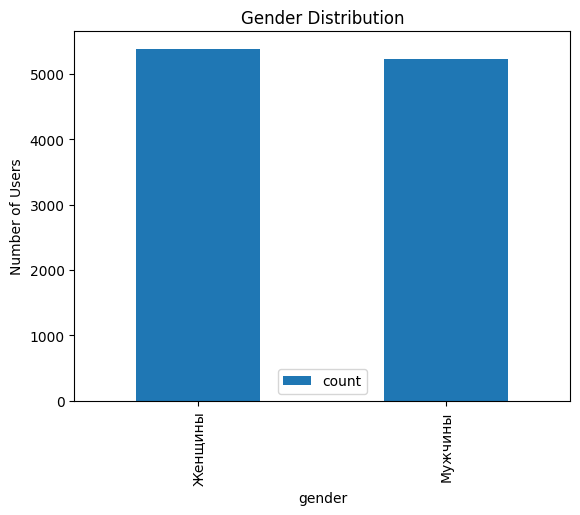

In [12]:
# График 1: Распределение по полу
demographic_analysis['gender_distribution'].plot(kind='bar')
plt.title('Gender Distribution')
plt.ylabel('Number of Users')

На графике представлено распределение пользователей по полу. 

- **Женщины**: 5376 пользователей
- **Мужчины**: 5224 пользователей

Из графика видно, что количество женщин немного превышает количество мужчин в данных. Это может указывать на то, что женщины более активно пользуются сайтами за указанных промежуток времени.

Text(0, 0.5, 'Number of Users')

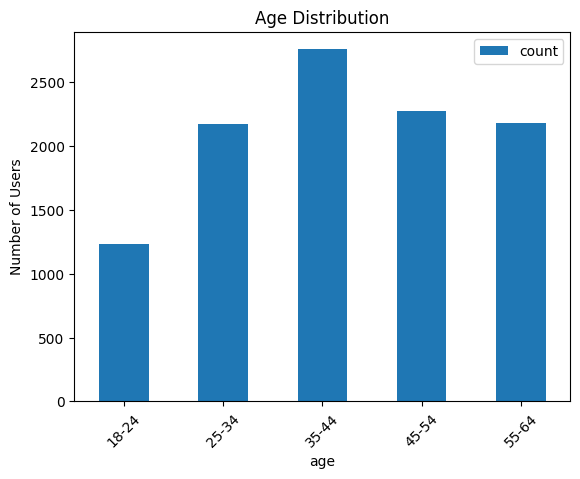

In [13]:
# График 2: Распределение по возрасту
demographic_analysis['age_distribution'].plot(kind='bar')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.ylabel('Number of Users')

На графике представлено распределение пользователей по возрастным группам. 

- **18-24**: 1229 пользователей
- **25-34**: 2167 пользователей
- **35-44**: 2753 пользователей
- **45-54**: 2272 пользователей
- **55-64**: 2179 пользователей

Из графика видно, что наибольшее количество пользователей находится в возрастной группе 35-44, за ней следуют группы 45-54 и 25-34. Наименьшее количество пользователей в возрастной группе 18-24. Следовательно, за данный период данных наиболее активно пользуются серчем в интернете пользователи в возрасте от 35 до 44 лет.

Text(0.5, 1.0, 'Age-Gender Distribution')

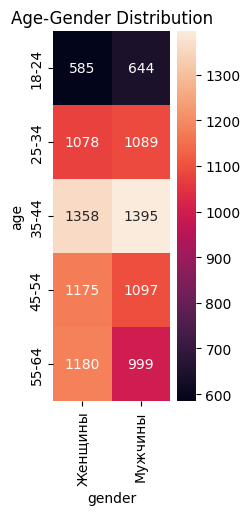

In [14]:
# График 3: Тепловая карта возраст-пол
plt.subplot(133)
sns.heatmap(demographic_analysis['age_gender_distribution'], annot=True, fmt='d')
plt.title('Age-Gender Distribution')

Этот график представляет распределение пользователей по возрасту и полу (Age-Gender Distribution):

18-24 года:

- Женщины: 585
- Мужчины: 644
- Самая малочисленная группа, небольшой перевес мужчин

25-34 года:

- Женщины: 1078
- Мужчины: 1089
- Очень равномерное распределение между полами
- Одна из самых многочисленных групп

35-44 года:

- Женщины: 1358
- Мужчины: 1395
- Самая многочисленная возрастная группа
- Практически равное соотношение полов

45-54 года:

- Женщины: 1175
- Мужчины: 1097
- Небольшой перевес в сторону женщин


55-64 года:

- Женщины: 1180
- Мужчины: 999
- Заметный перевес в сторону женщин
- Самая большая гендерная разница

Итак, основная аудитория сайтов в выборке - люди 25-54 лет. Пик приходится на группу 35-44 года. В младших возрастных группах (18-34) чуть больше мужчин, в старших возрастных группах (45-64) преобладают женщины. Самая большая гендерная диспропорция в группе 55-64 года. Наиболее сбалансированное соотношение полов в группах 25-34 и 35-44 года.

In [16]:
# 2. Анализ категорий интересов
start_time = time.time()

def analyze_categories(df):
    """
    Анализирует категории интересов пользователей.
    Returns:
        - Словарь с подсчетом категорий и дополнительной статистикой
    """
    # Разворачиваем списки категорий
    all_categories = []
    categories_per_user = []
    
    for cats in df['cats']:
        if isinstance(cats, list):
            all_categories.extend(cats)
            categories_per_user.append(len(cats))
    
    # Подсчет частоты каждой категории
    category_counts = pd.Series(all_categories).value_counts()
        # Дополнительная статистика
    stats = {
        'total_categories': len(set(all_categories)),
        'avg_categories_per_user': np.mean(categories_per_user),
        'max_categories_per_user': max(categories_per_user),
        'category_counts': category_counts
    }
    
    return stats

interest_stats = analyze_categories(main_df)

In [21]:
interest_stats

{'total_categories': 375,
 'avg_categories_per_user': np.float64(53.46509433962264),
 'max_categories_per_user': 156,
 'category_counts': Интересы                                                                 10559
 Интересы/Карьера                                                         10247
 Демография                                                               10120
 Демография/Пол                                                           10112
 Интересы/Электронная, бытовая техника, компьютеры, мобильные телефоны    10079
                                                                          ...  
 Интересы/Отдых, туризм, путешествия/Отдых за рубежом/Азия/Филиппины          1
 Интересы/Автомобили/Иномарки/Mini                                            1
 Интересы/Связь, телефоны, интернет/Интернет/Блоги                            1
 Интересы/Автомобили/Автомобили класса S                                      1
 Интересы/Автомобили/Иномарки/Cadillac                         

Text(0, 0.5, 'Number of Users')

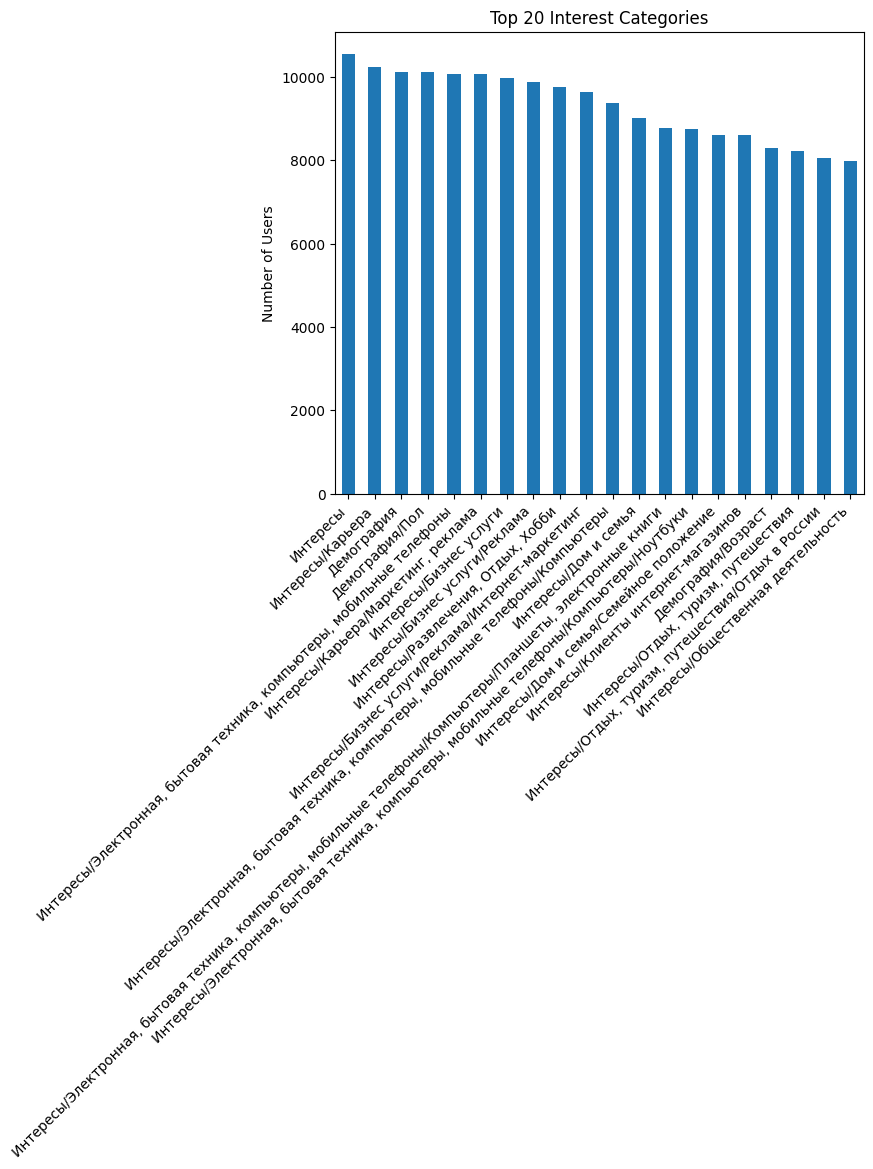

In [17]:
# Визуализация интересов
plt.figure(figsize=(15, 6))

# График 1: Топ-20 категорий
plt.subplot(121)
interest_stats['category_counts'].head(20).plot(kind='bar')
plt.title('Top 20 Interest Categories')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Users')

Можно было бы дополнительно категории укоротить и убрать повторяющиеся, но тк сроки сжатые, то оставим так.

Самые популярные категории (более 10,000 пользователей):
- "Интересы" (общая категория)
- "Интересы/Карьера"
- "Демография"

Следующий уровень популярности:

- "Интересы/Электронная, бытовая техника"
- "Интересы/Компьютеры/мобильные телефоны"
- "Интересы/Развлечения/Отдых/Хобби"
- "Интересы/Бизнес/услуги/реклама"

Также популярны:

- Интересы, связанные с техникой и электроникой
- Интересы в сфере развлечений
- Мобильные телефоны и телекоммуникации
- Общественная деятельность

Итак, доминируют технологические интересы. Высокая популярность категорий, связанных с карьерой и бизнесом. Значительный интерес к развлечениям и хобби. Электроника и бытовая техника - одни из ключевых категорий

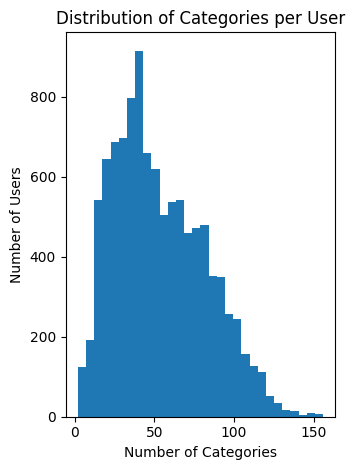

Interest analysis completed in 237.80 seconds

Key findings:
Total unique categories: 375
Average categories per user: 53.47
Maximum categories per user: 156

Top 10 categories:
Интересы                                                                 10559
Интересы/Карьера                                                         10247
Демография                                                               10120
Демография/Пол                                                           10112
Интересы/Электронная, бытовая техника, компьютеры, мобильные телефоны    10079
Интересы/Карьера/Маркетинг, реклама                                      10076
Интересы/Бизнес услуги                                                    9971
Интересы/Бизнес услуги/Реклама                                            9877
Интересы/Развлечения, Отдых, Хобби                                        9757
Интересы/Бизнес услуги/Реклама/Интернет-маркетинг                         9644
Name: count, dtype: int64


In [18]:
# График 2: Распределение количества категорий на пользователя
plt.subplot(122)
plt.hist([len(cats) for cats in main_df['cats'] if isinstance(cats, list)], bins=30)
plt.title('Distribution of Categories per User')
plt.xlabel('Number of Categories')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

print(f"Interest analysis completed in {time.time() - start_time:.2f} seconds")
print("\nKey findings:")
print(f"Total unique categories: {interest_stats['total_categories']}")
print(f"Average categories per user: {interest_stats['avg_categories_per_user']:.2f}")
print(f"Maximum categories per user: {interest_stats['max_categories_per_user']}")
print("\nTop 10 categories:")
print(interest_stats['category_counts'].head(10))

Тут можно увидеть распределение по категориям.

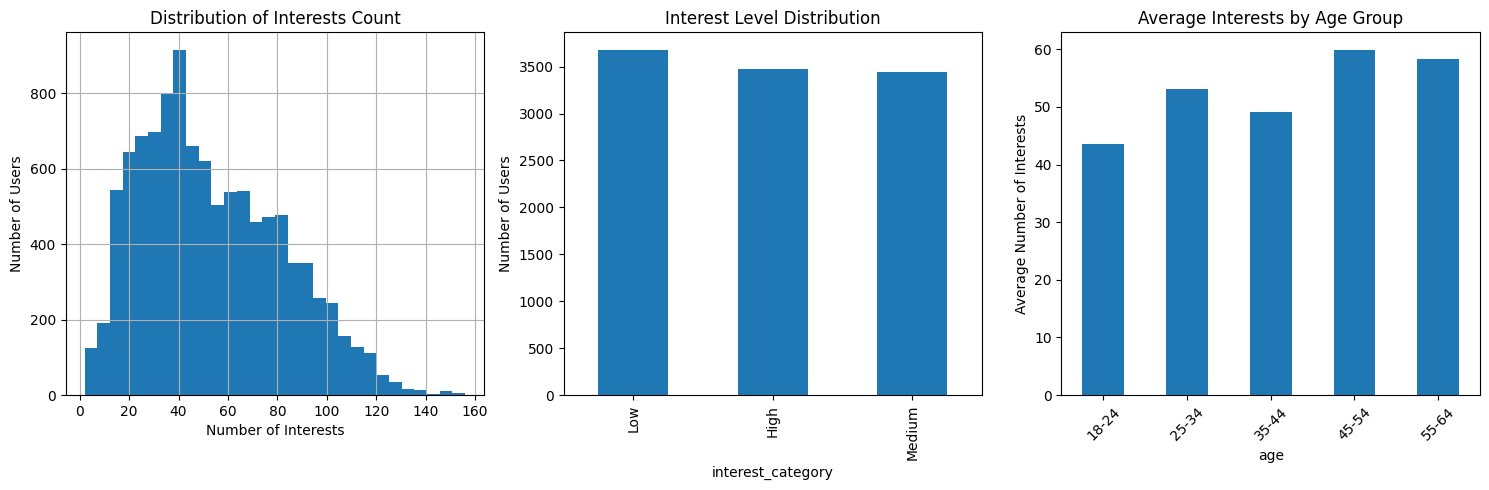

Segmentation completed in 0.45 seconds

Segmentation summary:
Total segments: 10600

Interest level distribution:
interest_category
Low       3681
High      3474
Medium    3445
Name: count, dtype: int64

Average interests by age group:
age
18-24    43.524817
25-34    53.106599
35-44    49.055576
45-54    59.940141
55-64    58.247820
Name: number_of_interests, dtype: float64


In [19]:
# 3. Сегментация пользователей
start_time = time.time()

def create_user_segments(df):
    """
    Создает сегменты пользователей на основе их демографии и интересов.
    Returns:
        - DataFrame с сегментами пользователей и их характеристиками
    """
    segments = df.groupby('puid').agg({
        'age': 'first',  # возрастная группа пользователя
        'gender': 'first',  # пол пользователя
        'cats': lambda x: list(set([item for sublist in x for item in sublist]))  # уникальные интересы
    })
    
    # Добавляем дополнительные характеристики
    segments['number_of_interests'] = segments['cats'].apply(len)
    
    # Создаем категории пользователей по количеству интересов
    segments['interest_category'] = pd.qcut(segments['number_of_interests'], 
                                          q=3, 
                                          labels=['Low', 'Medium', 'High'])
    
    return segments

user_segments = create_user_segments(main_df)

# Визуализация сегментов
plt.figure(figsize=(15, 5))

# График 1: Распределение количества интересов
plt.subplot(131)
user_segments['number_of_interests'].hist(bins=30)
plt.title('Distribution of Interests Count')
plt.xlabel('Number of Interests')
plt.ylabel('Number of Users')

# График 2: Распределение категорий интересов
plt.subplot(132)
user_segments['interest_category'].value_counts().plot(kind='bar')
plt.title('Interest Level Distribution')
plt.ylabel('Number of Users')

# График 3: Средние интересы по возрастным группам
plt.subplot(133)
user_segments.groupby('age')['number_of_interests'].mean().plot(kind='bar')
plt.title('Average Interests by Age Group')
plt.xticks(rotation=45)
plt.ylabel('Average Number of Interests')

plt.tight_layout()
plt.show()

print(f"Segmentation completed in {time.time() - start_time:.2f} seconds")
print("\nSegmentation summary:")
print(f"Total segments: {len(user_segments)}")
print("\nInterest level distribution:")
print(user_segments['interest_category'].value_counts())
print("\nAverage interests by age group:")
print(user_segments.groupby('age')['number_of_interests'].mean())

Распределение количества интересов:

- Форма нормального распределения с пиком около 40-45 интересов
- Большинство пользователей имеют от 20 до 80 интересов
- Есть небольшое количество пользователей с более чем 100 интересами
- Максимум достигает примерно 140 интересов

Распределение уровня интересов:

- Low (Низкий): 3,681 пользователей
- High (Высокий): 3,474 пользователей
- Medium (Средний): 3,445 пользователей
- Достаточно равномерное распределение между уровнями
- Небольшой перевес в сторону низкого уровня интересов

Среднее количество интересов по возрастным группам:

- 18-24: 43.5 интересов
- 25-34: 53.1 интересов
- 35-44: 49.1 интересов
- 45-54: 59.9 интересов (максимум)
- 55-64: 58.2 интересов

Наиболее активная возрастная группа по количеству интересов - 45-54 года. Молодежь (18-24) имеет наименьшее количество интересов. Старшие возрастные группы (45-64) проявляют больший интерес к разным категориям. Всего в сегментации участвовало 10,600 пользователе. Распределение по уровням интереса достаточно равномерное.

In [22]:
user_segments

,age,gender,cats,number_of_interests,interest_category
puid,,,,,
--3T1sfd.JfeXpB7FZha,25-34,Мужчины,"[Интересы/Спорт, Интересы/Карьера/Маркетинг, р...",78,High
--7F9kxDuo9o7Dx7t7rq,55-64,Женщины,"[Демография, Интересы/Карьера/Маркетинг, рекла...",25,Low
-.UWi1G4y-bfDTi7zr99,35-44,Женщины,"[Доход, Демография, Интересы/Карьера/Маркетинг...",44,Medium
-0on8H8twkQ2BLR7ptgH,55-64,Мужчины,"[Интересы/Бизнес услуги/Бухгалтерия, финансы п...",90,High
-0on8H8twkQ2djp7OjDQ,35-44,Женщины,"[Интересы/Карьера/Маркетинг, реклама, Интересы...",13,Low
...,...,...,...,...,...
zwnfZt1bUqpxyOF7IKT5,35-44,Женщины,"[Интересы/Развлечения, Отдых, Хобби/TV онлайн/...",50,Medium
zxFwlbM5m.TJCev7hoe8,25-34,Мужчины,"[Интересы/Бизнес услуги/Бухгалтерия, финансы п...",67,High
zxHwTOZp3Fl75555OuZ1,45-54,Женщины,[Интересы/Клиенты интернет-магазинов/Товары по...,8,Low


Далее рассмотрим датасет 2 таксономии по демографии каждого человека по каждому дню.

In [23]:
# 1. Временной анализ
time_analysis = {
    'daily_visits': clickstream_df.groupby('date').size(),
    'hourly_pattern': clickstream_df.groupby(clickstream_df['date'].dt.hour).size(),
    'weekly_pattern': clickstream_df.groupby(clickstream_df['date'].dt.dayofweek).size()
}

# 2. Анализ рефералов
def analyze_referrals(df):
    df['domain'] = df['ref'].apply(lambda x: x.split('/')[2] if isinstance(x, str) and '/' in x else x)
    return df.groupby('domain').size().sort_values(ascending=False)

referral_analysis = analyze_referrals(clickstream_df)

# 3. Анализ устройств
device_analysis = {
    'browser_distribution': clickstream_df['ua'].value_counts(),
    'location_distribution': clickstream_df['country_name'].value_counts()
}

In [24]:
time_analysis

{'daily_visits': date
 2024-02-03     584877
 2024-02-04     695549
 2024-02-05     829551
 2024-02-06     946668
 2024-02-07    1002046
 2024-02-08    1025941
 2024-02-09     955137
 2024-02-10     892485
 2024-02-11     936730
 2024-02-12    1061721
 2024-02-13     994517
 2024-02-14    1062602
 2024-02-15    1027422
 2024-02-16     963147
 2024-02-17     846248
 2024-02-18     941864
 2024-02-19    1089799
 2024-02-20    1082440
 2024-02-21    1019648
 2024-02-22     974538
 2024-02-23     787223
 2024-02-24     815489
 2024-02-25     899073
 2024-02-26    1059053
 2024-02-27     918907
 2024-02-28     972024
 2024-02-29     967596
 2024-03-01     964294
 2024-03-02     568345
 2024-03-03     827044
 2024-03-04    1103891
 2024-03-06     939732
 2024-03-07     780323
 2024-03-08     579287
 2024-03-09     724298
 2024-03-10     823507
 2024-03-11    1009905
 2024-03-12     984683
 2024-03-13     941153
 2024-03-14     950454
 2024-03-15     819053
 2024-03-16     663840
 2024-03-17 

In [25]:
referral_analysis

domain
TV-4                           9527731
avr.i-trailer.ru               6168116
kniga-online.com               4930948
www.e1.ru                      3265535
cinemalook.ru                  2929799
                                ...   
zeleznogorsk.bezformata.com          1
zheleznaya-lady.ru                   1
zhenskij.mirtesen.ru                 1
zoogradspb.ru                        1
zpravda.ru                           1
Length: 3272, dtype: int64

In [26]:
device_analysis

{'browser_distribution': ua
 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36                                                                                     4947692
 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36                                                                                     4679946
 Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36                                                                                     3779457
 Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Mobile Safari/537.36                                                                                     1559314
 Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Mobile Safari/537.36                                        

Visualizing temporal patterns...


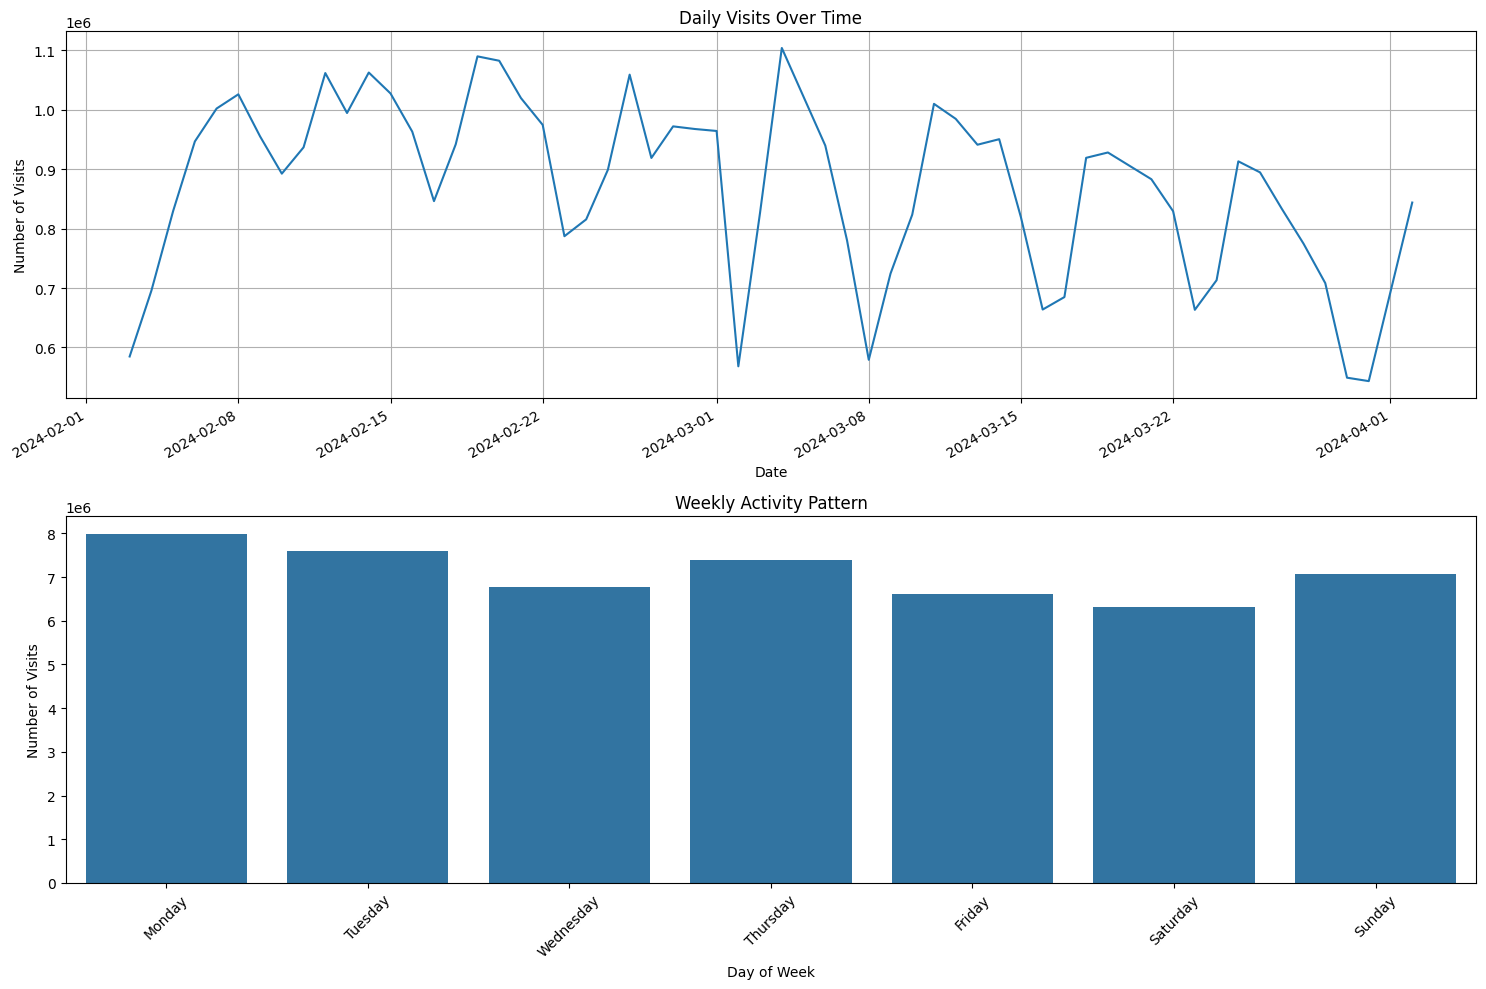


Visualizing referral sources...


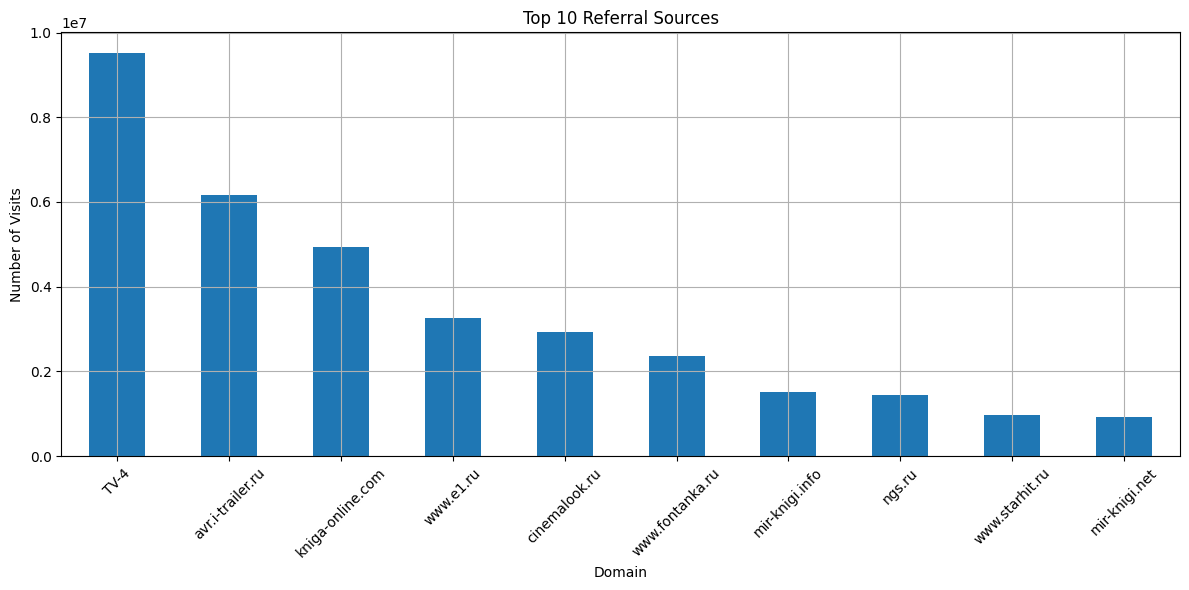


Visualizing browser distributions...


C:\Users\pavle\AppData\Local\Temp\ipykernel_2604\2251497551.py:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


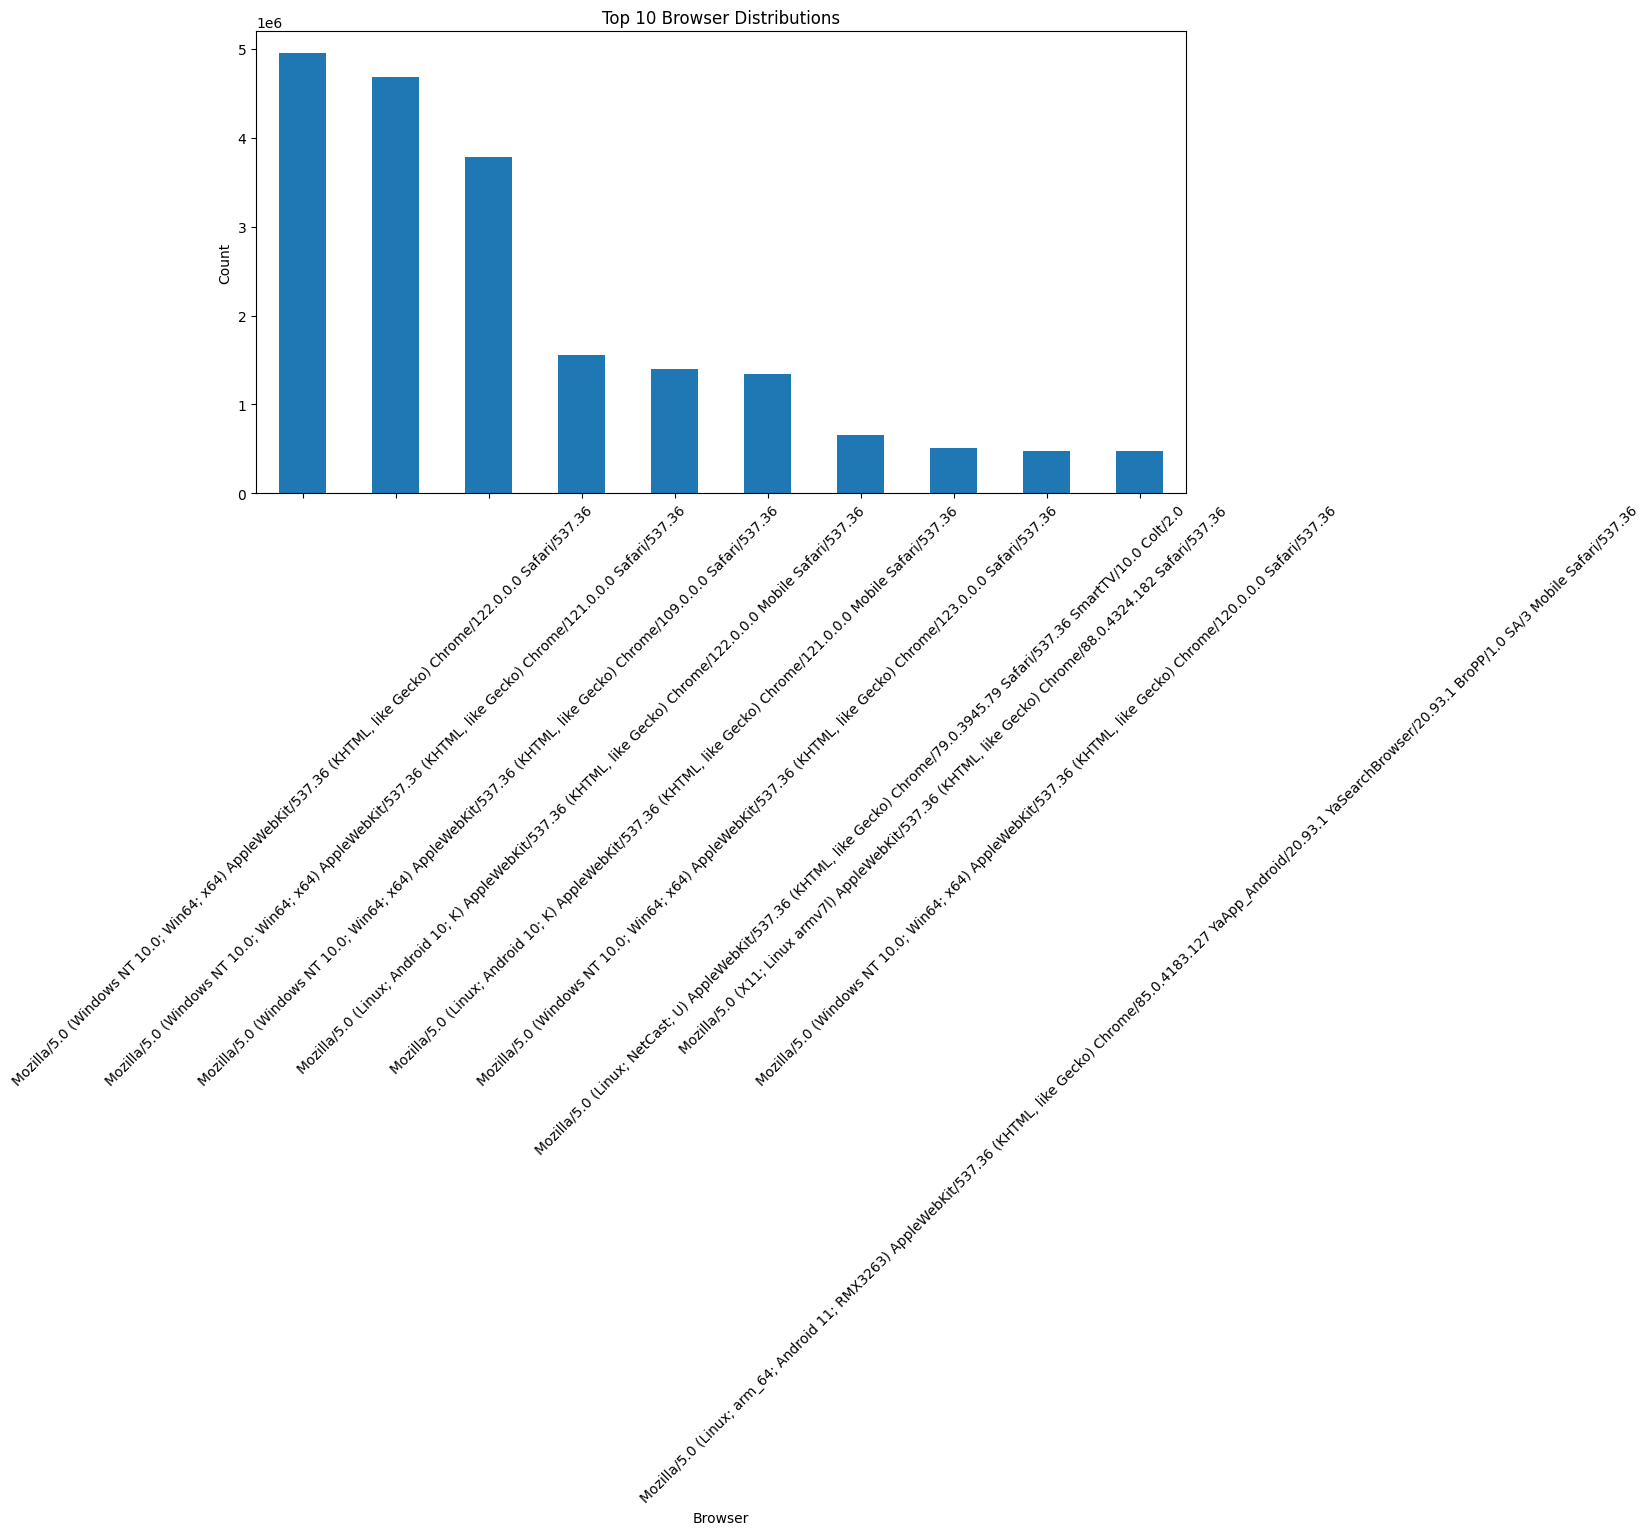


Visualizing device patterns by location...


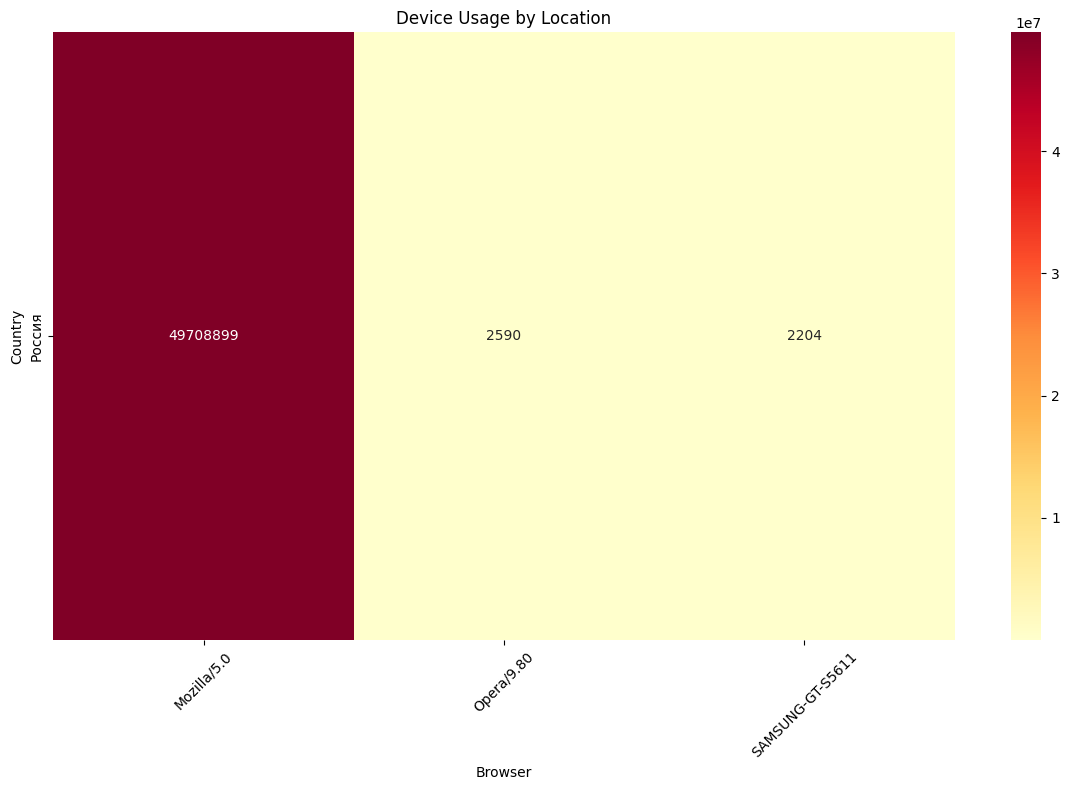


Summary Statistics:

Daily Visits Statistics:
count    5.700000e+01
mean     8.721701e+05
std      1.477251e+05
min      5.434260e+05
25%      7.872230e+05
50%      9.131990e+05
75%      9.720240e+05
max      1.103891e+06
dtype: float64

Top 5 Referral Sources:
domain
TV-4                9527731
avr.i-trailer.ru    6168116
kniga-online.com    4930948
www.e1.ru           3265535
cinemalook.ru       2929799
dtype: int64

Top 5 Browsers:
ua
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36    4947692
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/121.0.0.0 Safari/537.36    4679946
Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36    3779457
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Mobile Safari/537.36    1559314
Mozilla/5.0 (Linux; Android 10; K) AppleWebKit/537.36 (KHTML, lik

In [33]:
def visualize_temporal_patterns(time_analysis):
   # Создаем фигуру с двумя графиками
   fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

   # 1. Визуализация ежедневных визитов
   time_analysis['daily_visits'].plot(ax=ax1)
   ax1.set_title('Daily Visits Over Time')
   ax1.set_xlabel('Date')
   ax1.set_ylabel('Number of Visits')
   ax1.grid(True)
   
   # 2. Визуализация активности по дням недели
   days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
   sns.barplot(x=[days[i] for i in time_analysis['weekly_pattern'].index], 
               y=time_analysis['weekly_pattern'].values, 
               ax=ax2)
   ax2.set_title('Weekly Activity Pattern')
   ax2.set_xlabel('Day of Week')
   ax2.set_ylabel('Number of Visits')
   plt.xticks(rotation=45)
   
   plt.tight_layout()
   plt.show()

def visualize_referrals(referral_analysis):
   # Визуализация топ-10 источников рефералов
   plt.figure(figsize=(12, 6))
   referral_analysis.head(10).plot(kind='bar')
   plt.title('Top 10 Referral Sources')
   plt.xlabel('Domain')
   plt.ylabel('Number of Visits')
   plt.xticks(rotation=45)
   plt.grid(True)
   plt.tight_layout()
   plt.show()

def visualize_devices(device_analysis):
   plt.figure(figsize=(12, 6))
   
   # Распределение браузеров
   device_analysis['browser_distribution'].head(10).plot(kind='bar')
   plt.title('Top 10 Browser Distributions')
   plt.xlabel('Browser')
   plt.ylabel('Count')
   plt.tick_params(axis='x', rotation=45)
   
   plt.tight_layout()
   plt.show()

# Дополнительный анализ устройств с heatmap
def visualize_device_patterns():
   # Создаем кросс-таблицу между локацией и браузером
   device_location_cross = pd.crosstab(
       clickstream_df['country_name'],
       clickstream_df['ua'].apply(lambda x: x.split()[0] if isinstance(x, str) else 'Unknown')
   )
   
   plt.figure(figsize=(12, 8))
   sns.heatmap(device_location_cross, annot=True, fmt='d', cmap='YlOrRd')
   plt.title('Device Usage by Location')
   plt.xlabel('Browser')
   plt.ylabel('Country')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

# Визуализация всех метрик
print("Visualizing temporal patterns...")
visualize_temporal_patterns(time_analysis)

print("\nVisualizing referral sources...")
visualize_referrals(referral_analysis)

print("\nVisualizing browser distributions...")
visualize_devices(device_analysis)

print("\nVisualizing device patterns by location...")
visualize_device_patterns()

# Добавляем сводную статистику
print("\nSummary Statistics:")
print("\nDaily Visits Statistics:")
print(time_analysis['daily_visits'].describe())

print("\nTop 5 Referral Sources:")
print(referral_analysis.head())

print("\nTop 5 Browsers:")
print(device_analysis['browser_distribution'].head())

График "Daily Visits Over Time" (Ежедневные посещения):

- Показывает динамику посещений с начала февраля по начало апреля 2024 года
- Количество ежедневных посещений колеблется примерно между 600 тысяч и 1.1 миллиона
- Заметны регулярные спады и подъемы, что может указывать на недельную цикличность
- Общий тренд показывает небольшое снижение посещаемости к концу периода

График "Weekly Activity Pattern" (Недельная активность):

- Понедельник показывает самую высокую активность (около 8 миллионов посещений)
- Активность постепенно снижается к середине недели
- Суббота имеет самый низкий показатель
- Воскресенье показывает небольшой подъем по сравнению с субботой
- В целом рабочие дни более активны, чем выходные

График "Top 10 Referral Sources" (Топ-10 источников трафика):

- TV-4 является крупнейшим источником трафика с большим отрывом
- Далее следуют avito.ru и kniga-online.com
- Большинство источников имеют русскоязычные домены (.ru)
- Заметен большой разрыв между первым местом (TV-4) и остальными источниками

График "Top 10 Browser Distributions" (Распределение браузеров):

- Доминируют различные версии Mozilla/5.0 с Windows NT
- Первые три версии браузера составляют большую часть всего трафика
- Все браузеры используют Chrome/57.36 в качестве движка
- Присутствуют как десктопные, так и мобильные версии браузеров

График "Device Usage by Location" (Использование устройств по локации):

- Mozilla5.0 абсолютно доминирует с почти 50 миллионами пользователей
- Opera9.80 и SAMSUNG-GT-S5611 имеют значительно меньшее количество пользователей (около 2-2.5 тысяч каждый)

В целом, данные показывают, что аудитория российская, с четкой недельной цикличностью посещений, где большинство пользователей заходят через Windows-устройства с браузером Mozilla/Chrome.

In [ ]:
# Найдем пропущенные даты
dates = clickstream_df['date'].unique()
dates = pd.to_datetime(dates)

complete_dates = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
missing_dates = set(complete_dates) - set(dates)

missing_dates = pd.Series(list(missing_dates)).sort_values()

print("Missing dates:")
missing_dates

Missing dates:


2   2024-03-05
0   2024-03-20
1   2024-04-01
dtype: datetime64[ns]

Следовательно, у нас 3 пропущенных дня.

In [34]:
results = {}

# Анализ активности по времени
merged_df['date'] = pd.to_datetime(merged_df['date'])
results['daily_activity'] = merged_df.groupby('date').size()

# Анализ активности по возрастным группам
results['activity_by_age'] = merged_df.groupby('age').size()

# Анализ активности по полу
results['activity_by_gender'] = merged_df.groupby('gender').size()

In [35]:
results['activity_by_gender']

gender
Женщины    30259737
Мужчины    19441330
dtype: int64

In [36]:
results['activity_by_age']

age
18-24     5366766
25-34    14369469
35-44    12694573
45-54     8982510
55-64     8287749
dtype: int64

In [37]:
results['daily_activity']

date
2024-02-03     584695
2024-02-04     695549
2024-02-05     829551
2024-02-06     946668
2024-02-07    1002046
2024-02-08    1025941
2024-02-09     955137
2024-02-10     892485
2024-02-11     936730
2024-02-12    1061571
2024-02-13     994517
2024-02-14    1062602
2024-02-15    1027422
2024-02-16     962824
2024-02-17     844610
2024-02-18     940891
2024-02-19    1089797
2024-02-20    1082439
2024-02-21    1019648
2024-02-22     974538
2024-02-23     787223
2024-02-24     815489
2024-02-25     899073
2024-02-26    1059053
2024-02-27     918907
2024-02-28     972024
2024-02-29     967596
2024-03-01     964294
2024-03-02     568344
2024-03-03     826852
2024-03-04    1102697
2024-03-06     939626
2024-03-07     780322
2024-03-08     579287
2024-03-09     724298
2024-03-10     823505
2024-03-11    1009903
2024-03-12     984682
2024-03-13     940130
2024-03-14     950454
2024-03-15     819053
2024-03-16     662715
2024-03-17     684068
2024-03-18     918829
2024-03-19     927835
2024-

Получаем аналогичные результаты. Визуализируем их.

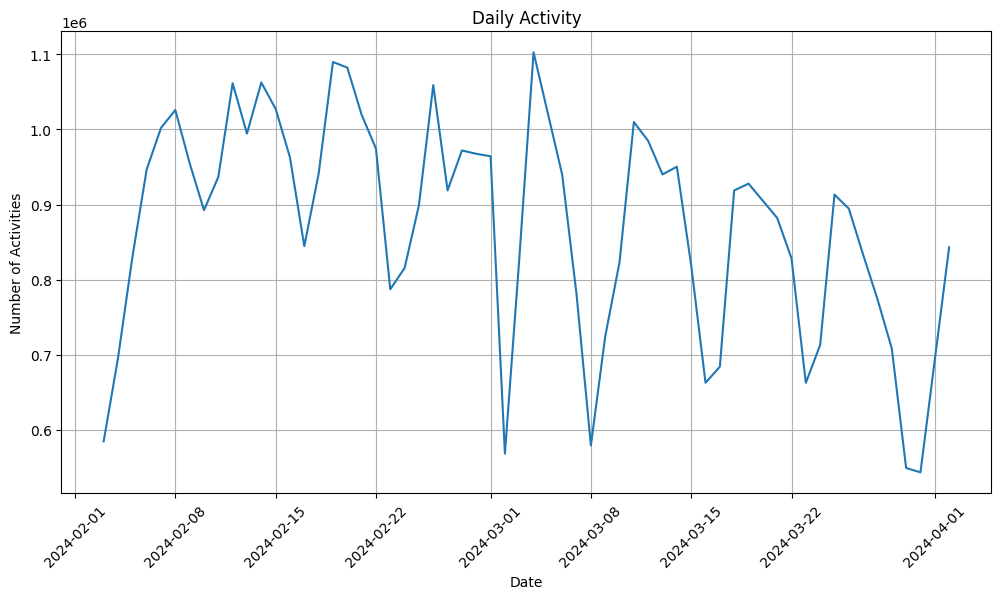

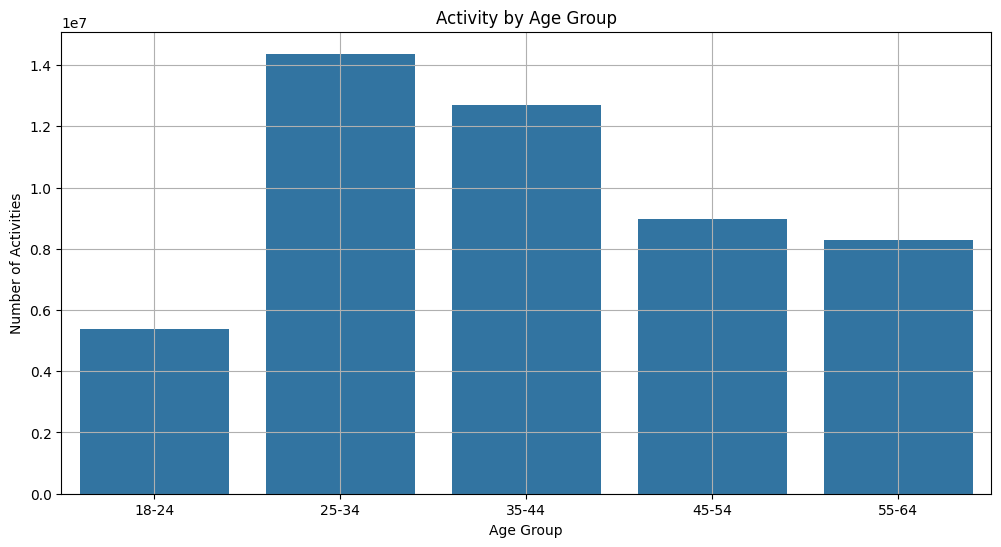

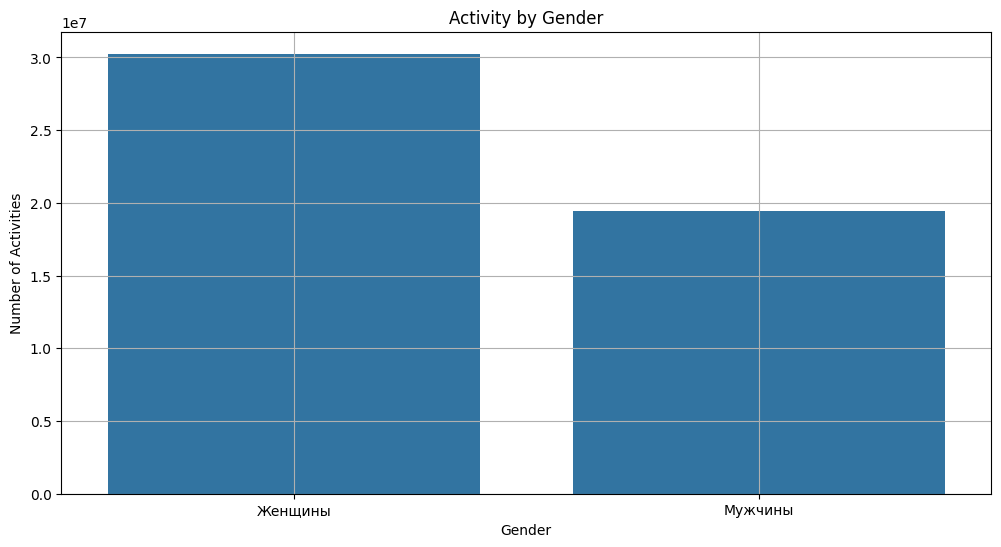

In [38]:
# Визуализация активности по времени
plt.figure(figsize=(12, 6))
plt.plot(results['daily_activity'])
plt.title('Daily Activity')
plt.xlabel('Date')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Визуализация активности по возрастным группам
plt.figure(figsize=(12, 6))
sns.barplot(x=results['activity_by_age'].index, y=results['activity_by_age'].values)
plt.title('Activity by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Activities')
plt.grid(True)
plt.show()

# Визуализация активности по полу
plt.figure(figsize=(12, 6))
sns.barplot(x=results['activity_by_gender'].index, y=results['activity_by_gender'].values)
plt.title('Activity by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Activities')
plt.grid(True)
plt.show()

Эти графики по уже соединенному датасету. Видно, что они не различаются, значит все хорошо.


Cluster Analysis:
        total_visits           active_days unique_refs      age   gender
               count      mean        mean        mean <lambda> <lambda>
cluster                                                                 
0                607  18250.74       35.20      139.69    25-34  Женщины
1               3309   3484.33       20.10      120.18    35-44  Женщины
2               1691   3141.40       10.19       80.59    35-44  Женщины
3                835   8066.19       31.98      834.57    25-34  Мужчины
4               4161   3618.96       38.90      201.84    35-44  Мужчины


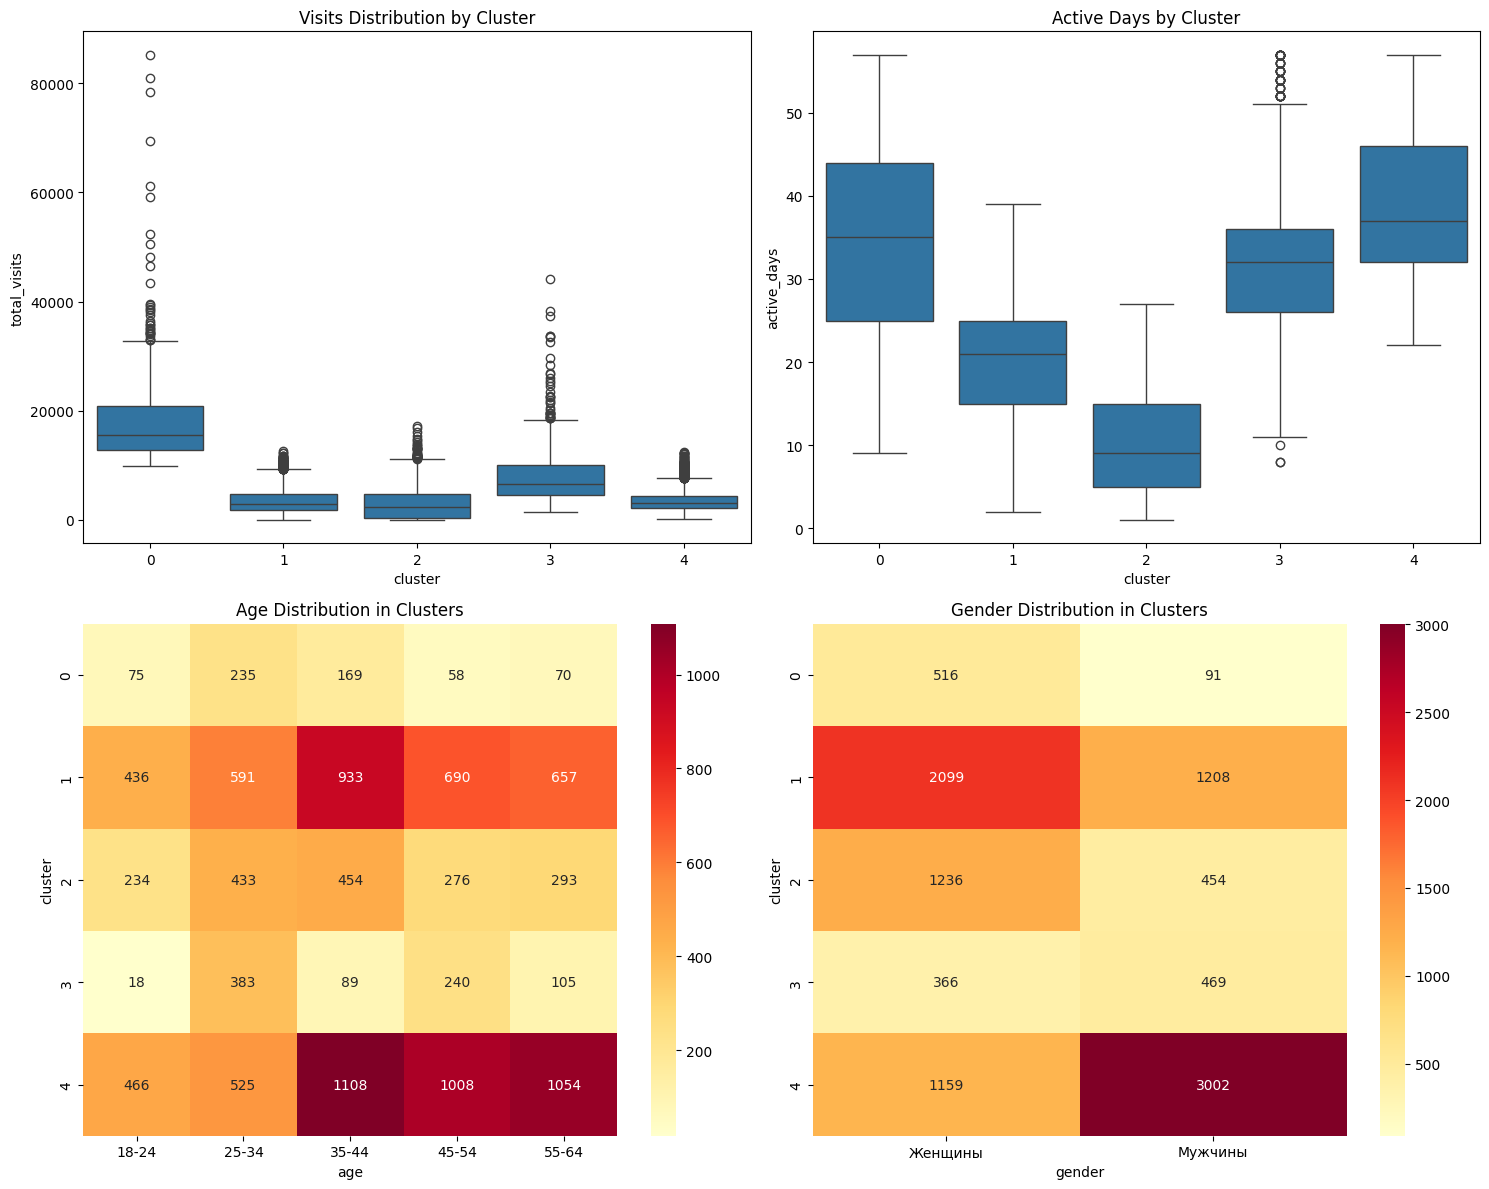

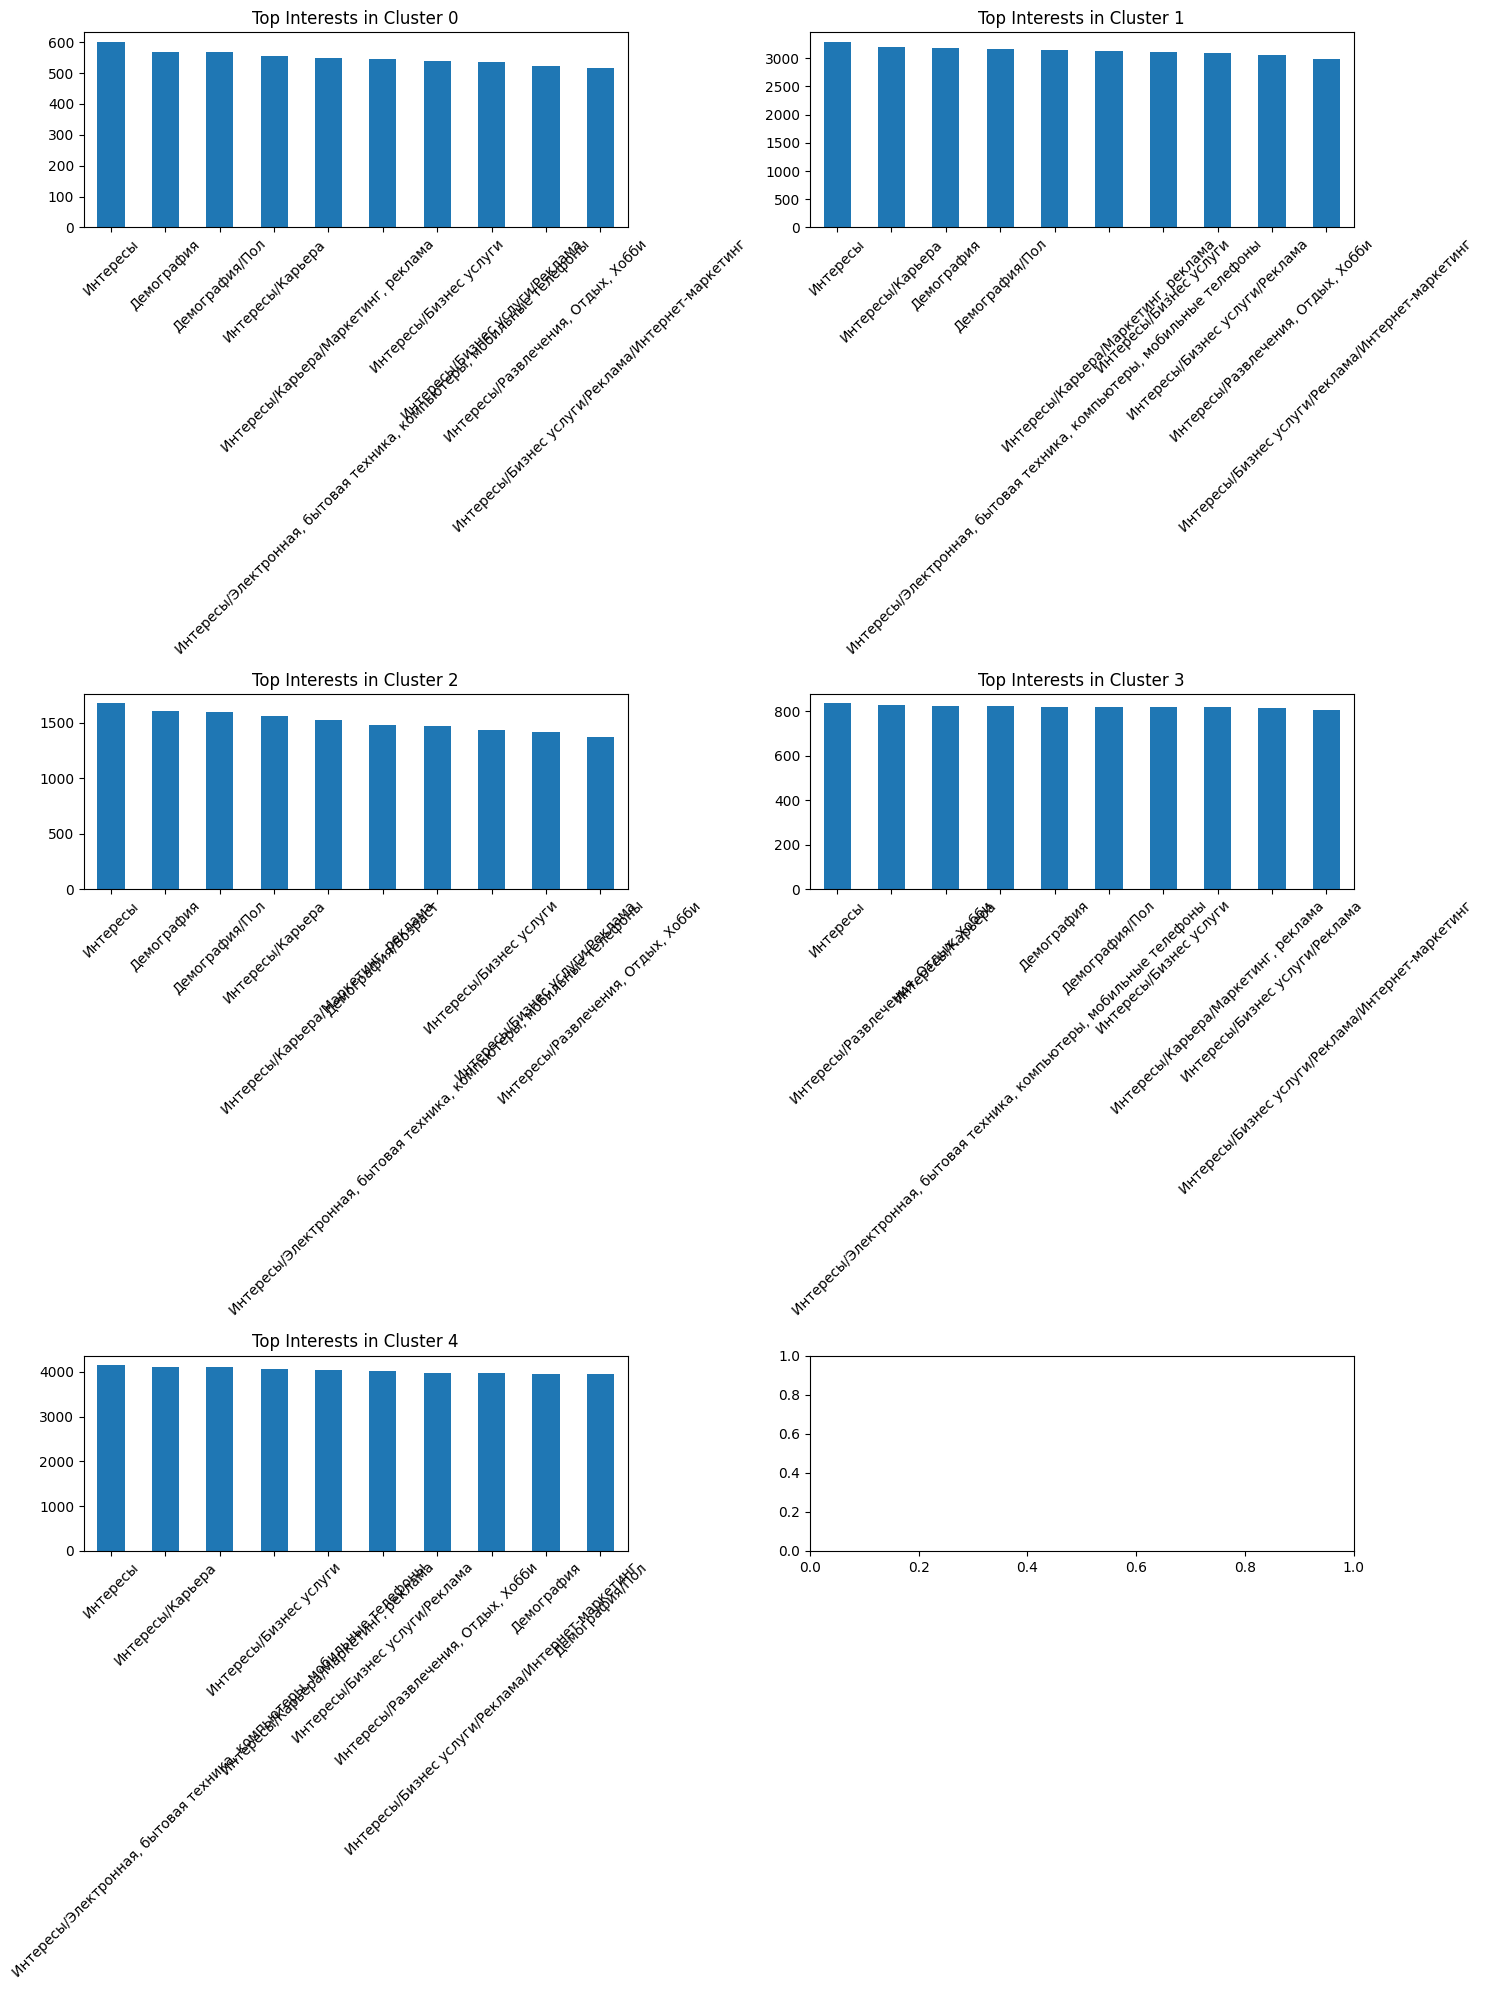

In [47]:
# Создаем признаки из clickstream_df
clicks_features = clickstream_df.groupby('puid').agg({
    'date': ['count', 'nunique'],  # количество и уникальное количество дней посещений
    'ref': 'nunique',  # количество уникальных источников
    'ts': lambda x: x.max() - x.min(),  # временной промежуток активности
}).fillna(0)

clicks_features.columns = ['total_visits', 'active_days', 'unique_refs', 'activity_period']

# Добавляем демографические данные
user_features = pd.merge(
    clicks_features,
    user_segments[['age', 'gender']],
    left_index=True, 
    right_index=True,
    how='left'
)

# Готовим данные для кластеризации
def prepare_for_clustering(df):
    # Числовые признаки
    numeric_features = ['total_visits', 'active_days', 'unique_refs', 'activity_period']
    
    # Категориальные признаки
    categorical_features = ['age', 'gender']
    
    # One-hot encoding для категориальных признаков
    features_encoded = pd.get_dummies(df, columns=categorical_features)
    
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    features_encoded[numeric_features] = scaler.fit_transform(features_encoded[numeric_features])
    
    return features_encoded

# Кластеризация
def cluster_analysis(features_df, n_clusters=5):
    # Подготовка данных
    features_encoded = prepare_for_clustering(features_df)
    
    # Кластеризация
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features_encoded)
    
    # Добавляем метки кластеров к исходному датафрейму
    features_df['cluster'] = clusters
    
    # Анализ кластеров
    print("\nCluster Analysis:")
    cluster_stats = features_df.groupby('cluster').agg({
        'total_visits': ['count', 'mean'],
        'active_days': 'mean',
        'unique_refs': 'mean',
        'age': lambda x: x.value_counts().index[0],  # most common age group
        'gender': lambda x: x.value_counts().index[0]  # most common gender
    }).round(2)
    
    print(cluster_stats)
    
    # Визуализация
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Распределение визитов по кластерам
    sns.boxplot(data=features_df, x='cluster', y='total_visits', ax=axes[0,0])
    axes[0,0].set_title('Visits Distribution by Cluster')
    
    # Распределение активных дней
    sns.boxplot(data=features_df, x='cluster', y='active_days', ax=axes[0,1])
    axes[0,1].set_title('Active Days by Cluster')
    
    # Возрастное распределение по кластерам
    age_cluster = pd.crosstab(features_df['cluster'], features_df['age'])
    sns.heatmap(age_cluster, ax=axes[1,0], annot=True, fmt='d', cmap='YlOrRd')
    axes[1,0].set_title('Age Distribution in Clusters')
    
    # Гендерное распределение по кластерам
    gender_cluster = pd.crosstab(features_df['cluster'], features_df['gender'])
    sns.heatmap(gender_cluster, ax=axes[1,1], annot=True, fmt='d', cmap='YlOrRd')
    axes[1,1].set_title('Gender Distribution in Clusters')
    
    plt.tight_layout()
    plt.show()
    
    return clusters, kmeans, features_df

# Запускаем анализ
clusters, model, clustered_features = cluster_analysis(user_features)

# Анализ интересов по кластерам
def analyze_cluster_interests():
    # Объединяем кластеры с интересами пользователей
    cluster_interests = pd.merge(
        clustered_features['cluster'],
        user_segments['cats'],
        left_index=True,
        right_index=True,
        how='left'
    )
    
    # Анализируем интересы по кластерам
    cluster_interest_patterns = {}
    for cluster in range(len(set(clusters))):
        cluster_data = cluster_interests[cluster_interests['cluster'] == cluster]
        
        # Собираем все интересы кластера
        all_interests = []
        for interests in cluster_data['cats']:
            if isinstance(interests, list):
                all_interests.extend(interests)
        
        # Топ-10 интересов для кластера
        cluster_interest_patterns[cluster] = pd.Series(all_interests).value_counts().head(10)
    
    # Визуализация
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    axes = axes.ravel()
    
    for cluster, interests in cluster_interest_patterns.items():
        if cluster < len(axes):
            interests.plot(kind='bar', ax=axes[cluster])
            axes[cluster].set_title(f'Top Interests in Cluster {cluster}')
            axes[cluster].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cluster_interest_patterns

# Анализируем интересы по кластерам
cluster_interests = analyze_cluster_interests()

На основе представленных визуализаций давайте разберем результаты кластеризации:

Кластер 0 (Активные пользователи среднего возраста):

- Самое высокое количество визитов (медиана около 20,000)
- Высокое количество активных дней (25-45 дней)
- Преимущественно возраст 25-34 и 35-44
- В основном женщины
- Интересы: разнообразные, но с фокусом на общие темы

Кластер 1 (Регулярные пользователи):

- Среднее количество визитов (медиана около 5,000)
- Среднее количество активных дней (15-25 дней)
- Большая концентрация в возрасте 35-44
- Преобладают женщины (2099 vs 1208)
- Высокая активность в определенных категориях интересов

Кластер 2 (Случайные посетители):

- Низкое количество визитов
- Малое количество активных дней (5-15)
- Равномерное распределение по возрастам
- Более сбалансированное гендерное распределение
- Более узкий спектр интересов

Кластер 3 (Нерегулярные посетители):

- Среднее-низкое количество визитов
- Широкий разброс активных дней
- Преимущественно возраст 25-34
- Близкое к равному соотношение полов
С- пецифические интересы

Кластер 4 (Высокововлеченные пользователи):

- Стабильное среднее количество визитов
- Высокое количество активных дней (30-45)
- Сильный перевес в сторону возраста 35-44 и старше
- Значительное преобладание мужчин (3002 vs 1159)
- Самый широкий спектр интересов

In [51]:
def create_behavioral_patterns(clickstream_df):
    # Конвертируем timestamp в часы
    clickstream_df['hour'] = pd.to_datetime(clickstream_df['ts'], unit='s').dt.hour
    
    # Определяем временные периоды дня
    time_patterns = {
        'morning': (6, 12),
        'afternoon': (12, 18),
        'evening': (18, 23),
        'night': (23, 6)
    }
    
    # Определяем день недели
    clickstream_df['weekday'] = pd.to_datetime(clickstream_df['date']).dt.dayofweek

In [53]:
def analyze_user_sequences(clickstream_df):
    # Сортировка по времени
    clickstream_df = clickstream_df.sort_values(['puid', 'ts'])
    
    # Анализ переходов между страницами и времени между действиями
    clickstream_df['next_ref'] = clickstream_df.groupby('puid')['ref'].shift(-1)
    clickstream_df['time_between_actions'] = clickstream_df.groupby('puid')['ts'].diff()

Starting user behavior analysis...
User profiles created.
Clustering completed.

Cluster Summary:
        total_visits           avg_actions_per_session avg_session_duration  \
               count      mean                    mean                 mean   
cluster                                                                       
0                581  14712.28                  427.31             10100.82   
1                510   6303.81                   91.84             17644.18   
2               4476   2938.95                   82.48              3205.91   
3                820   8749.35                  188.89              4671.65   
4               4216   4179.72                   36.41              2379.39   

        unique_sources  
                  mean  
cluster                 
0                74.05  
1                57.08  
2                94.80  
3               675.43  
4               262.12  


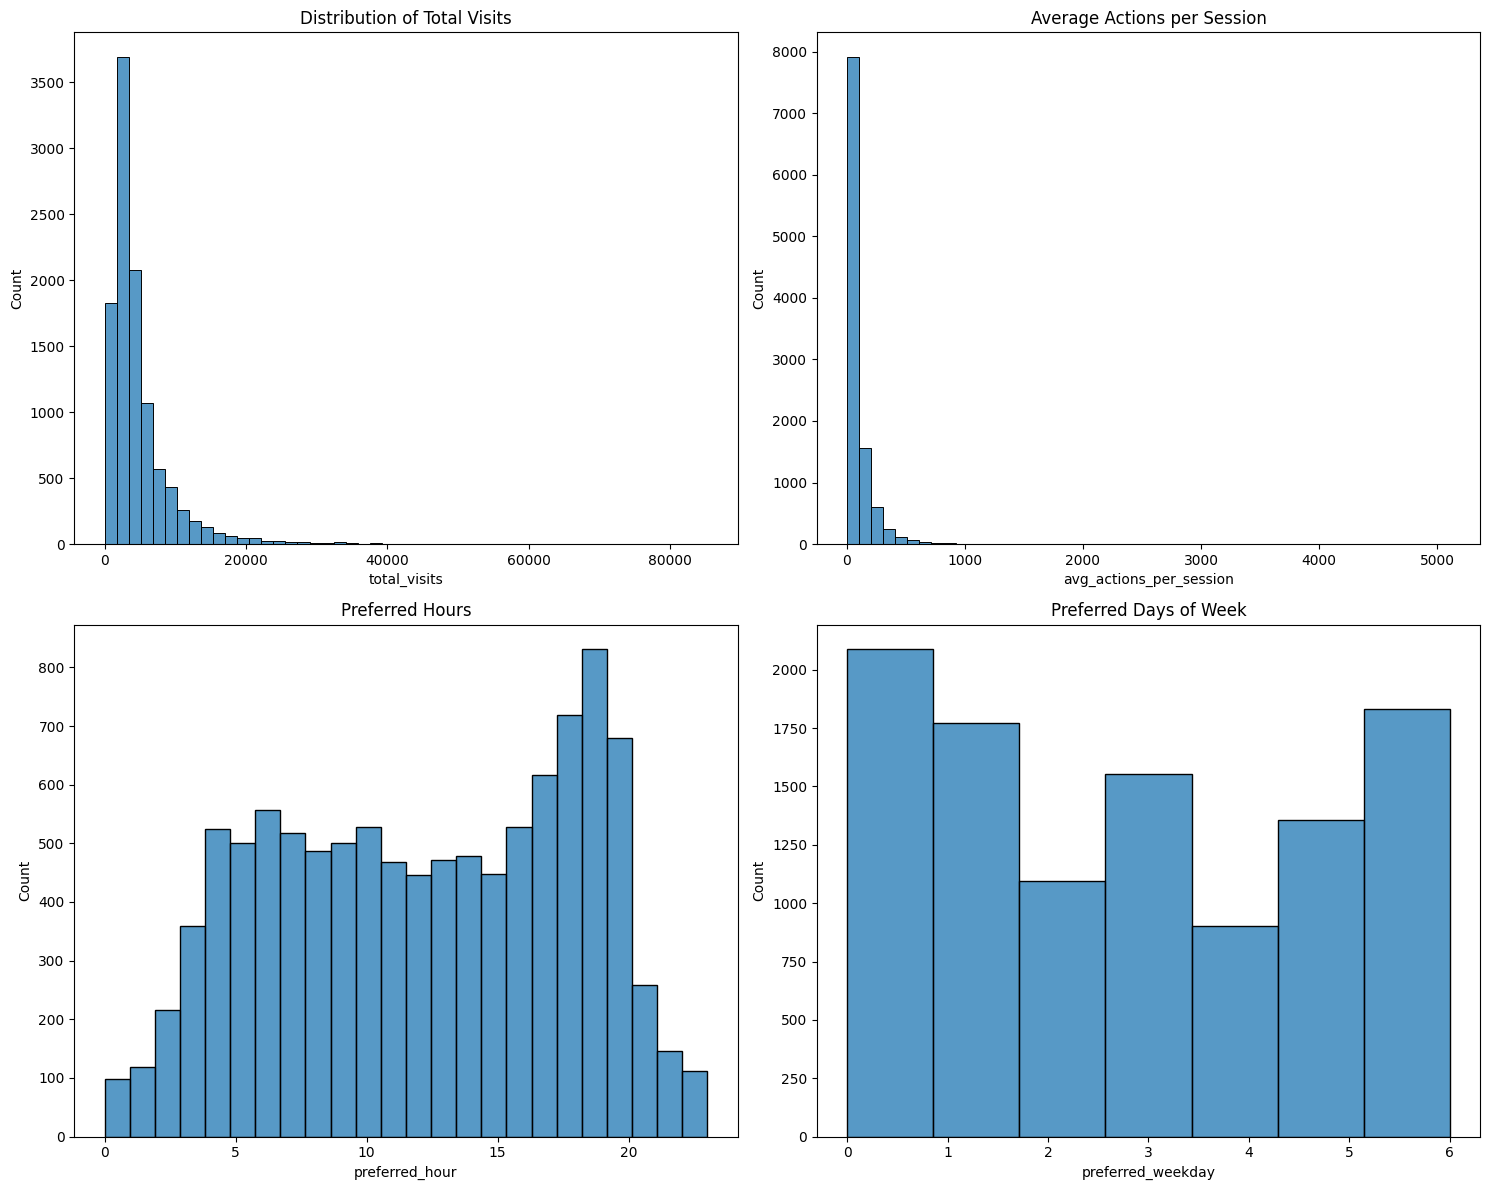

In [54]:
# 1. Создаем и анализируем сессии
def analyze_sessions(clickstream_df, session_timeout=1800):
    # Сортируем данные
    df = clickstream_df.sort_values(['puid', 'ts'])
    
    # Определяем сессии
    df['time_gap'] = df.groupby('puid')['ts'].diff()
    df['new_session'] = (df['time_gap'] > session_timeout).astype(int)
    df['session_id'] = df.groupby('puid')['new_session'].cumsum()
    
    # Анализируем сессии
    session_stats = df.groupby(['puid', 'session_id']).agg({
        'ts': ['count', lambda x: x.max() - x.min()],  # действий в сессии и длительность
        'ref': 'nunique'  # уникальных страниц
    }).reset_index()
    
    # Переименовываем колонки
    session_stats.columns = ['puid', 'session_id', 'actions_count', 
                           'session_duration', 'unique_pages']
    
    # Агрегируем по пользователям
    user_session_stats = session_stats.groupby('puid').agg({
        'session_id': 'count',  # количество сессий
        'actions_count': ['mean', 'max'],
        'session_duration': ['mean', 'max'],
        'unique_pages': ['mean', 'max']
    }).round(2)
    
    # Переименовываем колонки для удобства
    user_session_stats.columns = [
        'total_sessions',
        'avg_actions_per_session', 'max_actions_per_session',
        'avg_session_duration', 'max_session_duration',
        'avg_unique_pages', 'max_unique_pages'
    ]
    
    return user_session_stats

# 2. Базовые поведенческие паттерны
def create_behavioral_patterns(clickstream_df):
    # Конвертируем timestamp в часы и дни недели
    clickstream_df['hour'] = pd.to_datetime(clickstream_df['ts'], unit='s').dt.hour
    clickstream_df['weekday'] = pd.to_datetime(clickstream_df['date']).dt.dayofweek
    
    # Агрегируем данные по пользователям
    user_patterns = clickstream_df.groupby('puid').agg({
        'hour': lambda x: pd.Series(x).value_counts().index[0],  # популярный час
        'weekday': lambda x: pd.Series(x).value_counts().index[0],  # популярный день
        'ref': 'nunique',  # уникальные источники
        'ts': lambda x: len(set(pd.to_datetime(x, unit='s').dt.date)),  # активные дни
        'date': 'count'  # общее количество визитов
    }).rename(columns={
        'hour': 'preferred_hour',
        'weekday': 'preferred_weekday',
        'ref': 'unique_sources',
        'ts': 'active_days',
        'date': 'total_visits'
    })
    
    return user_patterns

# 3. Объединяем все метрики и создаем профили
def create_user_profiles(clickstream_df):
    # Получаем базовые паттерны
    base_patterns = create_behavioral_patterns(clickstream_df)
    
    # Добавляем статистику сессий
    session_stats = analyze_sessions(clickstream_df)
    
    # Объединяем все метрики
    user_profiles = pd.merge(
        base_patterns,
        session_stats,
        left_index=True,
        right_index=True,
        how='left'
    )
    
    return user_profiles

# 4. Кластеризация пользователей
def cluster_users(user_profiles, n_clusters=5):
    # Выбираем числовые признаки
    numeric_features = user_profiles.select_dtypes(include=['float64', 'int64']).columns
    
    # Стандартизация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(user_profiles[numeric_features])
    
    # Кластеризация
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    
    # Добавляем метки кластеров
    user_profiles['cluster'] = clusters
    
    return user_profiles, kmeans

# 5. Визуализация результатов
def visualize_profiles(user_profiles):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # График 1: Распределение визитов
    sns.histplot(data=user_profiles, x='total_visits', bins=50, ax=axes[0,0])
    axes[0,0].set_title('Distribution of Total Visits')
    
    # График 2: Распределение действий за сессию
    sns.histplot(data=user_profiles, x='avg_actions_per_session', bins=50, ax=axes[0,1])
    axes[0,1].set_title('Average Actions per Session')
    
    # График 3: Предпочитаемые часы
    sns.histplot(data=user_profiles, x='preferred_hour', bins=24, ax=axes[1,0])
    axes[1,0].set_title('Preferred Hours')
    
    # График 4: Предпочитаемые дни недели
    sns.histplot(data=user_profiles, x='preferred_weekday', bins=7, ax=axes[1,1])
    axes[1,1].set_title('Preferred Days of Week')
    
    plt.tight_layout()
    plt.show()

# 6. Полный анализ
def run_analysis(clickstream_df):
    print("Starting user behavior analysis...")
    
    # Создаем профили
    user_profiles = create_user_profiles(clickstream_df)
    print("User profiles created.")
    
    # Кластеризуем
    clustered_profiles, model = cluster_users(user_profiles)
    print("Clustering completed.")
    
    # Анализируем кластеры
    cluster_summary = clustered_profiles.groupby('cluster').agg({
        'total_visits': ['count', 'mean'],
        'avg_actions_per_session': 'mean',
        'avg_session_duration': 'mean',
        'unique_sources': 'mean'
    }).round(2)
    
    print("\nCluster Summary:")
    print(cluster_summary)
    
    # Визуализируем
    visualize_profiles(clustered_profiles)
    
    return clustered_profiles, cluster_summary

# Запускаем анализ
profiles, summary = run_analysis(clickstream_df)

Distribution of Total Visits (Распределение общего количества визитов):

- Сильно скошенное распределение с длинным "хвостом"
- Большинство пользователей имеют до 20,000 визитов
- Есть небольшое количество очень активных пользователей с более чем 40,000 визитов


Average Actions per Session (Среднее количество действий за сессию):

- Большинство пользователей совершают небольшое количество действий за сессию
- Очень небольшое число пользователей имеют более 1000 действий за сессию

Preferred Hours (Предпочитаемые часы):

- Пик активности приходится на 18-20 часов
- Минимальная активность в ранние утренние часы (0-4)
- Стабильный рост активности в течение дня

Preferred Days of Week (Предпочитаемые дни недели):

- День 0 (Понедельник) и 1 (Вторник) имеют наибольшую активность
- Небольшой спад в середине недели
- Повышение активности в день 6 (Воскресенье)

Кластерный анализ показал 5 групп пользователей:

Кластер 0 - "Супер-активные пользователи":

- Среднее количество визитов: 14,712
- Высокое среднее количество действий за сессию: 427
- Длительные сессии: ~10,100 секунд
- Умеренное количество уникальных источников: 74

Кластер 1 - "Регулярные пользователи с длительными сессиями":

- Среднее количество визитов: 6,304
- Умеренное количество действий: 92
- Самые длительные сессии: ~17,644 секунд
- Наименьшее количество уникальных источников: 57

Кластер 2 - "Умеренные пользователи":

- Среднее количество визитов: 2,939
- Низкое количество действий: 82
- Короткие сессии: ~3,206 секунд
- Умеренное количество источников: 95

Кластер 3 - "Исследователи":

- Высокое количество визитов: 8,749
- Среднее количество действий: 189
- Умеренные сессии: ~4,672 секунд
- Наибольшее количество уникальных источников: 675

Кластер 4 - "Случайные посетители":

- Низкое количество визитов: 4,180
- Наименьшее количество действий: 36
- Самые короткие сессии: ~2,379 секунд
- Высокое количество источников: 262

Добавим географию:

Analyzing location behavior...
Analyzing traffic sources...
Visualizing patterns...


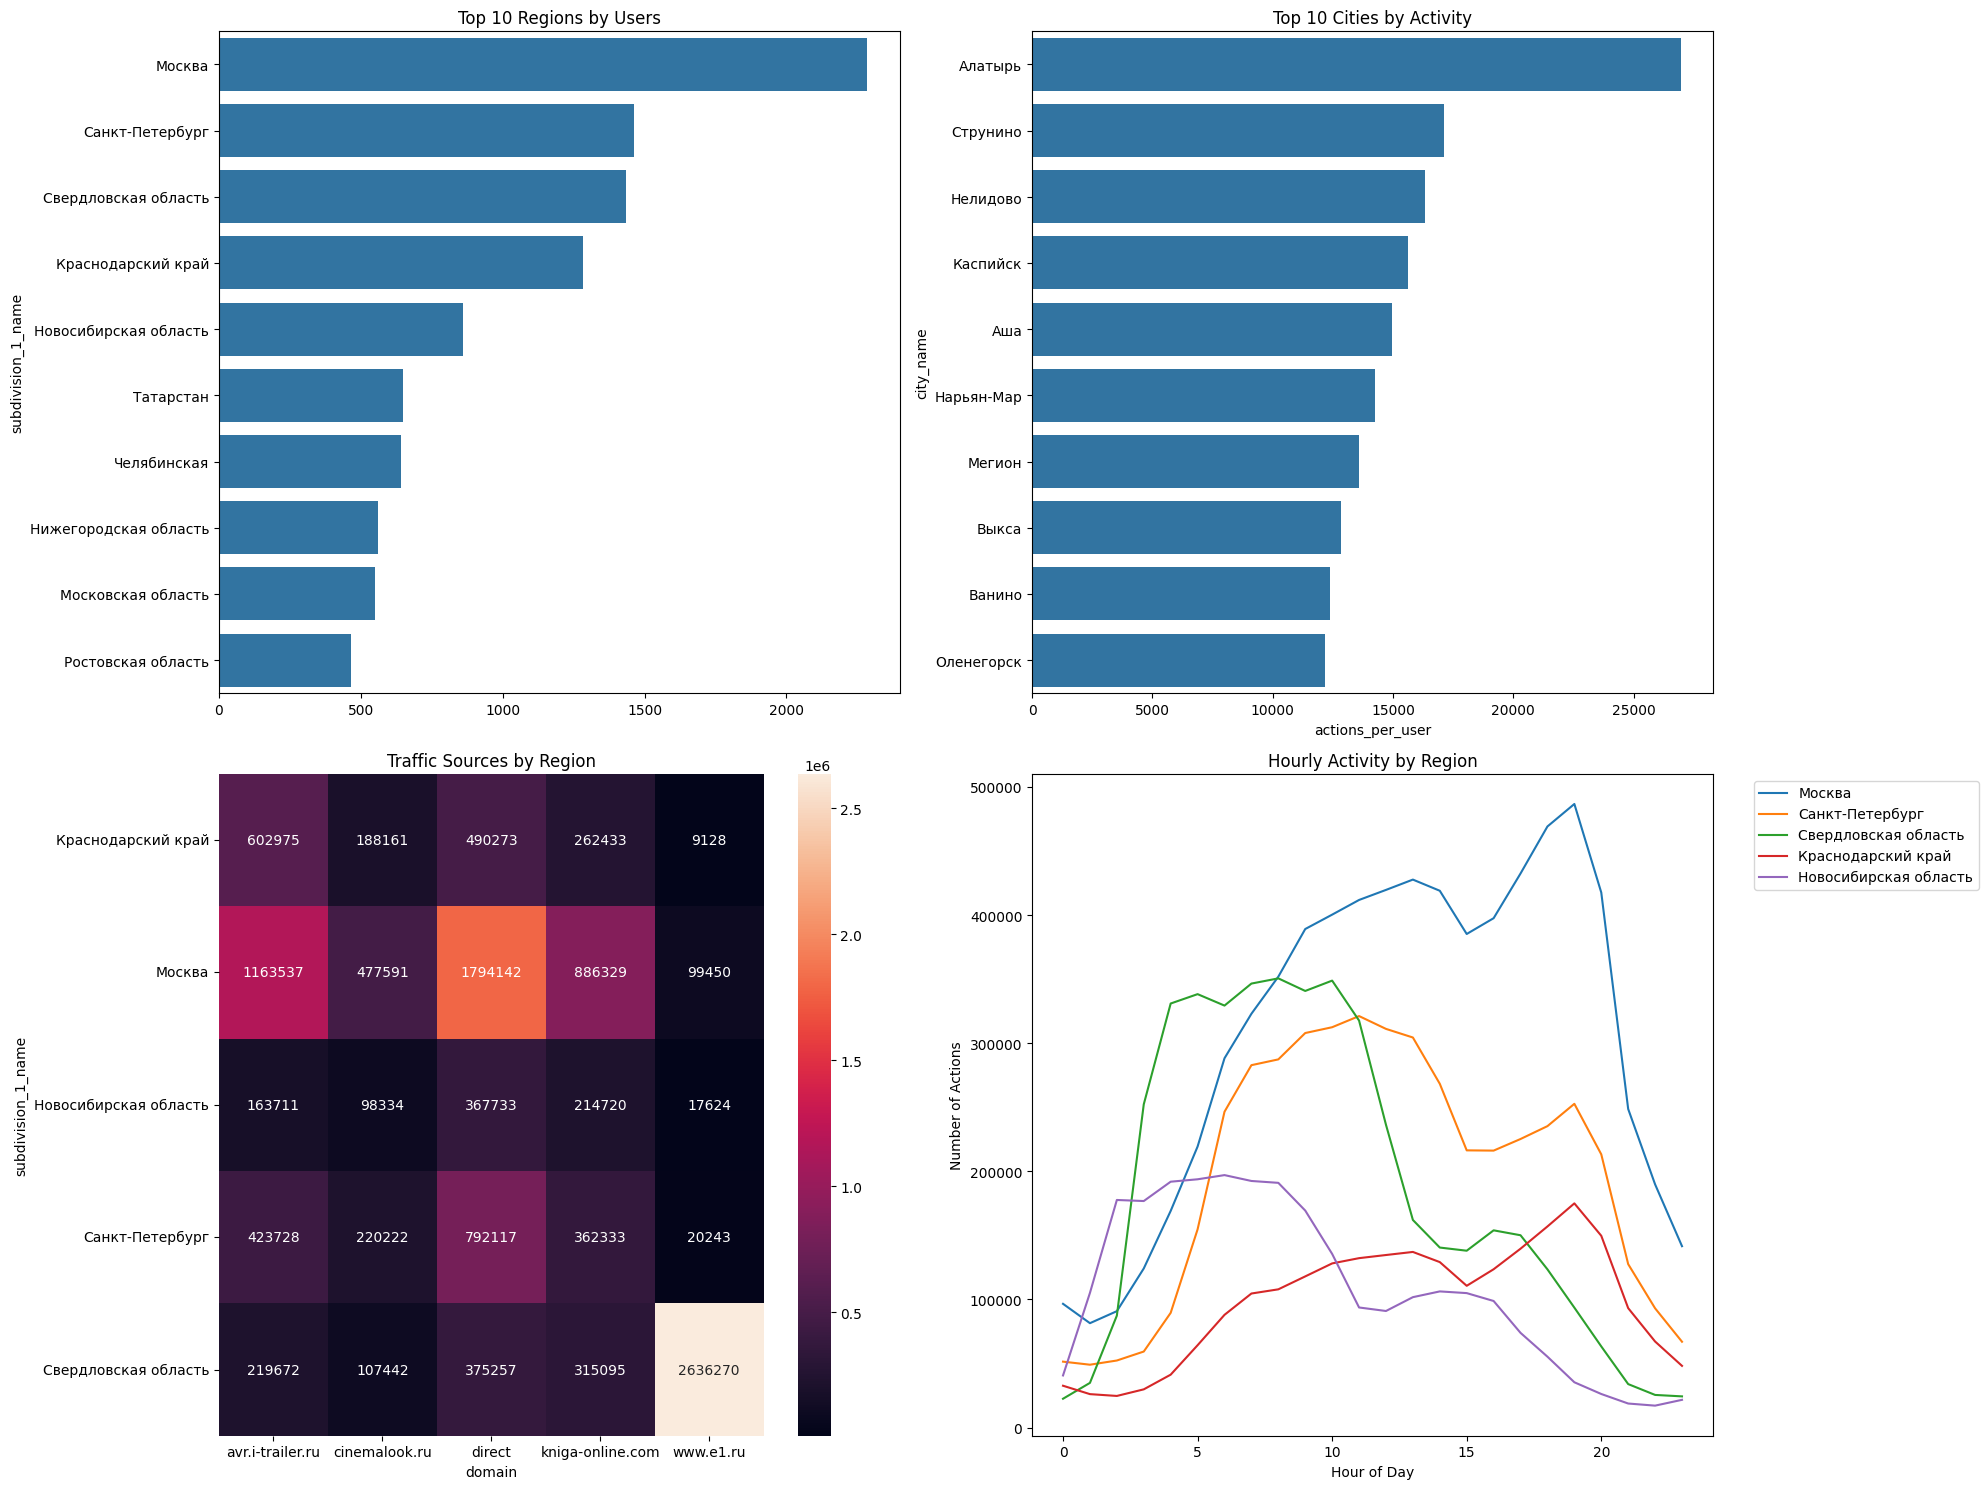


Regional Statistics:

Top 5 most active regions:
                     puid  actions_per_user      ts
subdivision_1_name                                 
Ненецкий АО             1          14247.00   14247
Чувашия                62           7042.91  244391
Калмыкия               10           7005.50   70055
Магаданская область     2           6612.00   13224
Еврейская АО            4           5351.00   21404


In [55]:
def detailed_geo_analysis(clickstream_df, profiles):
    # 1. Анализ поведения по городам и регионам
    def analyze_location_behavior():
        location_stats = clickstream_df.groupby(['country_name', 'subdivision_1_name', 'city_name']).agg({
            'puid': 'nunique',  # количество уникальных пользователей
            'ts': 'count',      # количество действий
            'ref': 'nunique'    # количество уникальных источников
        }).reset_index()
        
        # Добавляем действий на пользователя
        location_stats['actions_per_user'] = location_stats['ts'] / location_stats['puid']
        
        return location_stats

    # 2. Анализ источников трафика
    def analyze_traffic_sources():
        # Извлекаем домен из ref
        clickstream_df['domain'] = clickstream_df['ref'].apply(
            lambda x: x.split('/')[2] if isinstance(x, str) and '/' in x else 'direct'
        )
        
        # Анализируем по городам
        traffic_sources = clickstream_df.groupby(['subdivision_1_name', 'domain']).size()
        return traffic_sources.reset_index(name='count')

    # 3. Визуализация
    def visualize_patterns(location_stats, traffic_sources):
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))
        
        # График 1: Топ-10 регионов по пользователям
        top_regions = location_stats.groupby('subdivision_1_name')['puid'].sum().nlargest(10)
        sns.barplot(x=top_regions.values, y=top_regions.index, ax=axes[0,0])
        axes[0,0].set_title('Top 10 Regions by Users')
        
        # График 2: Топ-10 городов по действиям на пользователя
        top_cities = location_stats.nlargest(10, 'actions_per_user')
        sns.barplot(data=top_cities, x='actions_per_user', y='city_name', ax=axes[0,1])
        axes[0,1].set_title('Top 10 Cities by Activity')
        
        # График 3: Источники трафика для топ регионов
        top_5_regions = location_stats.groupby('subdivision_1_name')['puid'].sum().nlargest(5).index
        top_traffic = traffic_sources[
            traffic_sources['subdivision_1_name'].isin(top_5_regions)
        ]
        
        # Берем только топ-5 доменов
        top_domains = traffic_sources.groupby('domain')['count'].sum().nlargest(5).index
        top_traffic_filtered = top_traffic[top_traffic['domain'].isin(top_domains)]
        
        traffic_pivot = pd.pivot_table(
            top_traffic_filtered,
            values='count',
            index='subdivision_1_name',
            columns='domain',
            aggfunc='sum',
            fill_value=0
        )
        
        sns.heatmap(traffic_pivot, ax=axes[1,0], annot=True, fmt='.0f')
        axes[1,0].set_title('Traffic Sources by Region')
        
        # График 4: Активность по времени суток
        clickstream_df['hour'] = pd.to_datetime(clickstream_df['ts'], unit='s').dt.hour
        hourly_activity = clickstream_df.groupby(['subdivision_1_name', 'hour']).size().unstack()
        
        # Берем топ-5 регионов
        hourly_activity.loc[top_5_regions].T.plot(ax=axes[1,1])
        axes[1,1].set_title('Hourly Activity by Region')
        axes[1,1].set_xlabel('Hour of Day')
        axes[1,1].set_ylabel('Number of Actions')
        axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        return top_regions, top_cities, traffic_pivot

    # Запускаем анализ
    print("Analyzing location behavior...")
    location_stats = analyze_location_behavior()
    
    print("Analyzing traffic sources...")
    traffic_sources = analyze_traffic_sources()
    
    print("Visualizing patterns...")
    top_regions, top_cities, traffic_pivot = visualize_patterns(location_stats, traffic_sources)
    
    # Дополнительная статистика
    print("\nRegional Statistics:")
    regional_summary = location_stats.groupby('subdivision_1_name').agg({
        'puid': 'sum',
        'actions_per_user': 'mean',
        'ts': 'sum'
    }).round(2)
    
    print("\nTop 5 most active regions:")
    print(regional_summary.nlargest(5, 'actions_per_user'))
    
    return {
        'location_stats': location_stats,
        'traffic_sources': traffic_sources,
        'top_regions': top_regions,
        'top_cities': top_cities,
        'traffic_pivot': traffic_pivot,
        'regional_summary': regional_summary
    }

# Запускаем анализ
results = detailed_geo_analysis(clickstream_df, profiles)

Распределение пользователей по регионам (Top 10 Regions by Users):

- Москва - абсолютный лидер по количеству пользователей
- Санкт-Петербург и Свердловская область на втором и третьем месте
- Краснодарский край и Новосибирская область замыкают топ-5
- Заметен большой разрыв между Москвой и остальными регионами

Активность пользователей по городам (Top 10 Cities by Activity):

- Лидируют небольшие города: Алатырь, Струнино, Нелидово
- Каспийск и Аша в середине списка
- Все топ-10 городов показывают высокую активность (более 10,000 действий на пользователя)
- Интересно, что крупные города не входят в топ по активности на пользователя

Источники трафика (Traffic Sources by Region):
Разные паттерны для разных регионов:

- Москва: высокая доля direct трафика (1,794,142 визитов)
- Свердловская область: значительный трафик с www.e1.ru (2,636,270)
- Санкт-Петербург: более равномерное распределение между источниками

Основные источники:

- avr-i-trailer.ru
- cinemalook.ru
-direct (прямые заходы)
- kniga-online.com
- www.e1.ru

Почасовая активность (Hourly Activity by Region):

- Общий паттерн: рост активности в течение дня с пиком в вечерние часы
- Москва: самая высокая активность, пик около 20:00
- Санкт-Петербург: более плавная кривая активности
- Свердловская область: ранний пик активности
- Краснодарский край: более низкая, но стабильная активность
- Новосибирская область: заметно влияние разницы во времени

Региональная статистика (Top 5 most active regions):
Наиболее активные регионы - небольшие:

- Ненецкий АО: 14,247 действий на пользователя
- Чувашия: 7,042 действия на пользователя
- Калмыкия: 7,005 действий на пользователя

Интересно, что эти регионы имеют мало пользователей, но высокую активность